 <span style="color:#42a5f5; font-size:2em; font-weight:bold;">Mod√©lisation des s√©ries temporelles sur les donn√©es d'incidents</span>

Pr√©vision des Incidents des Pompiers de Londres 

L'objectif √©tant de pr√©dire les interventions futurs des pompiers dans les ann√©es √† venir afin de mieux organiser leur equipes, leurs materiel, et leur temps d'interventions ...

<span style="color:#e91e63; font-size:1em; font-weight:bold;">1. Import des biblioth√®ques necessaires</span>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import os
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

# Pour afficher toutes les colonnes
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

<span style="color:#e91e63; font-size:1em; font-weight:bold;">2-Chargement des donn√©es et v√©rifications </span>

In [2]:
# Chargement
processed_file_path = r"..\..\data\raw\Cleaned_data\InUSE\cleaned_data_incidents.csv"
if not os.path.exists(processed_file_path):
    raise FileNotFoundError(f"Le fichier {processed_file_path} n'existe pas. Veuillez v√©rifier le chemin.")

print(f"Chargement du fichier : {processed_file_path}")

# Colonnes utiles pour la time series
cols_to_keep = [
    "IncidentNumber", "DateOfCall", "TimeOfCall", "HourOfCall", "IncidentGroup", "IncGeo_BoroughName",
    "NumCalls", "NotionalCost", "PumpCount",
    "NumPumpsAttending", "NumStationsWithPumpsAttending"
]

# Typage strict uniquement sur les colonnes conserv√©es
dtype_map = {
    "IncidentNumber": "string",
    "TimeOfCall": "string",
    "HourOfCall": "Int64",
    "IncidentGroup": "string",
    "IncGeo_BoroughName": "string",
    "NumCalls": "Int64",
    "NotionalCost": "Int64",
    "PumpCount": "Int64",
    "NumPumpsAttending": "Int64",
    "NumStationsWithPumpsAttending": "Int64",
}

Chargement du fichier : ..\..\data\raw\Cleaned_data\InUSE\cleaned_data_incidents.csv


<span style="color:#e91e63; font-size:1em; font-weight:bold;">3-Analyse et v√©rification des colonnes √† mettre en Index date temps </span>

In [3]:
print(" ~~ D√©but de la Mod√©lisation des S√©ries Temporelles ~~ ")

#V√©rification des datas charg√©es et leur formatpour la suite:
# Chargement avec conversion explicite
df = pd.read_csv(processed_file_path, usecols=cols_to_keep, dtype=dtype_map, parse_dates=['DateOfCall'], dayfirst=True)
# V√©rification du chargement
print(f"- Chargement du fichier {processed_file_path} r√©ussi.")
# V√©rification des types de donn√©es
print("- Types de donn√©es dans le DataFrame :")
print(df.dtypes)
#v√©rification des valeurs manquantes
print("- Valeurs manquantes par colonne :")
print(df.isnull().sum())
# V√©rification des bornes
print(f"P√©riode : de {df['DateOfCall'].min()} √† {df['DateOfCall'].max()}")
# V√©rifie les types uniques dans ta colonne DateOfCall
print(df['DateOfCall'].apply(type).value_counts())

'''~~~~~~~~~~~~~~~~~~~~'''

# convertir en datetime pour l'indexation: 
df['DateOfCall'] = pd.to_datetime(df['DateOfCall'])
#v√©rification des datas apres convertion de DateOfCall en datetime pour l'indexation: 
print("-Type de la colonne DateOfCall :", df['DateOfCall'].dtype)
print("-Aper√ßu des valeurs de DateOfCall :")
display(df[['DateOfCall']].drop_duplicates().head(5))

print("\n-Aper√ßu des 5 premi√®res lignes du DataFrame :")
display(df.head(5))
print("types de donn√©es dans le DataFrame :")
print(df.dtypes)

# V√©rification des valeurs manquantes
print("-Valeurs manquantes par colonne :")
print(df.isnull().sum())

print("\n-Statistiques descriptives :")
display(df.describe(include='all'))

print("-P√©riode de la s√©rie temporelle :")   
print(f"De: {df['DateOfCall'].min()} au: {df['DateOfCall'].max()}")

 ~~ D√©but de la Mod√©lisation des S√©ries Temporelles ~~ 
- Chargement du fichier ..\..\data\raw\Cleaned_data\InUSE\cleaned_data_incidents.csv r√©ussi.
- Types de donn√©es dans le DataFrame :
IncidentNumber                   string[python]
DateOfCall                               object
TimeOfCall                       string[python]
HourOfCall                                Int64
IncidentGroup                    string[python]
IncGeo_BoroughName               string[python]
NumStationsWithPumpsAttending             Int64
NumPumpsAttending                         Int64
PumpCount                                 Int64
NotionalCost                              Int64
NumCalls                                  Int64
dtype: object
- Valeurs manquantes par colonne :
IncidentNumber                       0
DateOfCall                           0
TimeOfCall                           0
HourOfCall                           0
IncidentGroup                        6
IncGeo_BoroughName                 

DateOfCall
0    2009-01-01
405  2009-01-02
709  2009-01-03
1093 2009-01-04
1524 2009-01-05


-Aper√ßu des 5 premi√®res lignes du DataFrame :


IncidentNumber DateOfCall TimeOfCall  HourOfCall    IncidentGroup  \
0      235138081 2009-01-01   00:00:37           0  Special Service   
1           1091 2009-01-01   00:00:46           0  Special Service   
2           2091 2009-01-01   00:03:00           0             Fire   
3           3091 2009-01-01   00:04:27           0             Fire   
4           5091 2009-01-01   00:05:39           0             Fire   

  IncGeo_BoroughName  NumStationsWithPumpsAttending  NumPumpsAttending  \
0         WANDSWORTH                              2                  2   
1            LAMBETH                           <NA>               <NA>   
2            ENFIELD                              1                  1   
3         HILLINGDON                              1                  1   
4          ISLINGTON                              1                  2   

   PumpCount  NotionalCost  NumCalls  
0          2           255         1  
1          1           255         1  
2          1           255         2  
3          1           255         2  
4          2           255         1

types de donn√©es dans le DataFrame :
IncidentNumber                   string[python]
DateOfCall                       datetime64[ns]
TimeOfCall                       string[python]
HourOfCall                                Int64
IncidentGroup                    string[python]
IncGeo_BoroughName               string[python]
NumStationsWithPumpsAttending             Int64
NumPumpsAttending                         Int64
PumpCount                                 Int64
NotionalCost                              Int64
NumCalls                                  Int64
dtype: object
-Valeurs manquantes par colonne :
IncidentNumber                       0
DateOfCall                           0
TimeOfCall                           0
HourOfCall                           0
IncidentGroup                        6
IncGeo_BoroughName                   0
NumStationsWithPumpsAttending    14622
NumPumpsAttending                14622
PumpCount                            0
NotionalCost                       

IncidentNumber                     DateOfCall TimeOfCall  HourOfCall  \
count         1824973                        1824973    1824973   1824973.0   
unique        1824973                            NaN      86394        <NA>   
top             21091                            NaN   18:02:06        <NA>   
freq                1                            NaN         56        <NA>   
mean              NaN  2017-03-12 20:50:59.275944960        NaN   13.462605   
min               NaN            2009-01-01 00:00:00        NaN         0.0   
25%               NaN            2012-09-29 00:00:00        NaN         9.0   
50%               NaN            2017-04-15 00:00:00        NaN        14.0   
75%               NaN            2021-09-02 00:00:00        NaN        19.0   
max               NaN            2025-03-31 00:00:00        NaN        23.0   
std               NaN                            NaN        NaN    6.258045   

       IncidentGroup IncGeo_BoroughName  NumStationsWithPumpsAttending  \
count        1824967            1824973                      1810351.0   
unique             3                 33                           <NA>   
top      False Alarm        WESTMINSTER                           <NA>   
freq          894018             133650                           <NA>   
mean             NaN                NaN                       1.370929   
min              NaN                NaN                            1.0   
25%              NaN                NaN                            1.0   
50%              NaN                NaN                            1.0   
75%              NaN                NaN                            2.0   
max              NaN                NaN                           46.0   
std              NaN                NaN                       0.687726   

        NumPumpsAttending  PumpCount  NotionalCost   NumCalls  
count           1810351.0  1824973.0     1824973.0  1823124.0  
unique               <NA>       <NA>          <NA>       <NA>  
top                  <NA>       <NA>          <NA>       <NA>  
freq                 <NA>       <NA>          <NA>       <NA>  
mean             1.555361   1.592914    407.816033   1.327807  
min                   1.0        1.0         255.0        1.0  
25%                   1.0        1.0         290.0        1.0  
50%                   1.0        1.0         328.0        1.0  
75%                   2.0        2.0         364.0        1.0  
max                 106.0      951.0     2277726.0      369.0  
std              0.845371   1.582791   2701.663304   1.487098

-P√©riode de la s√©rie temporelle :
De: 2009-01-01 00:00:00 au: 2025-03-31 00:00:00


In [4]:
#v√©rification des valeurs manquantes
print("Valeurs manquantes par colonne :")
print(df.isnull().sum())

# Pr√©processing et traitement des valeurs manquantes de la colonne IncidentGroup qui contient 6 valeurs manquantes
# Remplacement des valeurs manquantes dans 'IncidentGroup' par 'False Alarm'
df['IncidentGroup'].fillna('False Alarm', inplace=True)

# V√©rification que l'imputation a fonctionn√©
missing_after = df['IncidentGroup'].isnull().sum()
print(f"Valeurs manquantes restantes dans IncidentGroup : {missing_after}")

# Contr√¥le de la r√©partition finale
print("\nR√©partition des valeurs dans IncidentGroup apr√®s imputation :")
print(df['IncidentGroup'].value_counts())

Valeurs manquantes par colonne :
IncidentNumber                       0
DateOfCall                           0
TimeOfCall                           0
HourOfCall                           0
IncidentGroup                        6
IncGeo_BoroughName                   0
NumStationsWithPumpsAttending    14622
NumPumpsAttending                14622
PumpCount                            0
NotionalCost                         0
NumCalls                          1849
dtype: int64
Valeurs manquantes restantes dans IncidentGroup : 0

R√©partition des valeurs dans IncidentGroup apr√®s imputation :
IncidentGroup
False Alarm        894024
Special Service    598275
Fire               332674
Name: count, dtype: Int64


In [ ]:
'''#V√©rification des donn√©es entre le 3 et 31 mars 2025
print("\n- V√©rification des donn√©es entre le 3 et 31 mars 2025 :")
# Conversion 
df['DateOfCall'] = pd.to_datetime(df['DateOfCall'], dayfirst=True, errors='coerce')

# S√©lection des lignes entre 3 mars et 31 mars 2025
mask_march25 = (df['DateOfCall'] >= '2025-03-03') & (df['DateOfCall'] <= '2025-03-31')
df_march25 = df.loc[mask_march25, ['DateOfCall', 'TimeOfCall']]

# V√©rifiCATION s'il y a des valeurs manquantes dans TimeOfCall
missing_time = df_march25['TimeOfCall'].isna().sum()
total_rows = df_march25.shape[0]

print(f"\nSur {total_rows} lignes entre le 3 et le 31 mars 2025 :")
print(f"- {missing_time} lignes ont TimeOfCall manquant")
print(f"- {total_rows - missing_time} lignes ont un TimeOfCall valide")

# V2RIFIE SIR IL Y A Des lignes manquantes
if missing_time > 0:
    print("\nVoici un aper√ßu des lignes concern√©es (DateOfCall sans TimeOfCall) :")
    display(df_march25[df_march25['TimeOfCall'].isna()])'''


- V√©rification des donn√©es entre le 3 et 31 mars 2025 :

Sur 340 lignes entre le 3 et le 31 mars 2025 :
- 0 lignes ont TimeOfCall manquant
- 340 lignes ont un TimeOfCall valide



<span style="color:#e91e63; font-size:1em; font-weight:bold;">4-Construction de l'Indexation</span>

In [5]:
# Si n√©cessaire, on trie d'abord les dates
df = df.sort_values('DateOfCall')
#cree la colonne datetemi me √† partir de DateOfCall et TimeOfCall
# On cr√©e une colonne DateTime √† partir de DateOfCall et TimeOfCall
df['DateTime'] = pd.to_datetime(df['DateOfCall'].astype(str) + ' ' + df['TimeOfCall'], errors='coerce')
# V√©rification de la conversion
print("\n- Type de la colonne DateTime :", df['DateTime'].dtype)    


# On cr√©e une colonne d√©di√©e
df['DateOfCall_str'] = df['DateOfCall'].dt.strftime('%Y-%m-%d')

# On fait une copie de la colonne pour l'index (index datetime)
df = df.set_index('DateTime').sort_index()

# V√©rification visuelle
print("\nIndexation OK")
print(f"Index DateOfCall : de {df.index.min().date()} √† {df.index.max().date()}")
print(f"Nombre de lignes index√©es : {df.shape[0]}")

# DateOfCall_str si besoin d'une version lisible
display(df.head())


- Type de la colonne DateTime : datetime64[ns]

Indexation OK
Index DateOfCall : de 2009-01-01 √† 2025-03-31
Nombre de lignes index√©es : 1824973


IncidentNumber DateOfCall TimeOfCall  HourOfCall  \
DateTime                                                               
2009-01-01 00:00:37      235138081 2009-01-01   00:00:37           0   
2009-01-01 00:00:46           1091 2009-01-01   00:00:46           0   
2009-01-01 00:03:00           2091 2009-01-01   00:03:00           0   
2009-01-01 00:04:27           3091 2009-01-01   00:04:27           0   
2009-01-01 00:05:39           5091 2009-01-01   00:05:39           0   

                       IncidentGroup IncGeo_BoroughName  \
DateTime                                                  
2009-01-01 00:00:37  Special Service         WANDSWORTH   
2009-01-01 00:00:46  Special Service            LAMBETH   
2009-01-01 00:03:00             Fire            ENFIELD   
2009-01-01 00:04:27             Fire         HILLINGDON   
2009-01-01 00:05:39             Fire          ISLINGTON   

                     NumStationsWithPumpsAttending  NumPumpsAttending  \
DateTime                                                                
2009-01-01 00:00:37                              2                  2   
2009-01-01 00:00:46                           <NA>               <NA>   
2009-01-01 00:03:00                              1                  1   
2009-01-01 00:04:27                              1                  1   
2009-01-01 00:05:39                              1                  2   

                     PumpCount  NotionalCost  NumCalls DateOfCall_str  
DateTime                                                               
2009-01-01 00:00:37          2           255         1     2009-01-01  
2009-01-01 00:00:46          1           255         1     2009-01-01  
2009-01-01 00:03:00          1           255         2     2009-01-01  
2009-01-01 00:04:27          1           255         2     2009-01-01  
2009-01-01 00:05:39          2           255         1     2009-01-01

In [ ]:
'''# V√©rifie que TimeOfCall est bien une cha√Æne au format hh:mm:ss
# Si jamais TimeOfCall n'a pas les secondes, on les ajoute artificiellement
df['TimeOfCall'] = df['TimeOfCall'].apply(lambda x: x if len(x.split(':')) == 3 else x + ':00')

# Maintenant, tu peux forcer DateTime proprement
df['DateTime'] = pd.to_datetime(df['DateOfCall'].dt.strftime('%Y-%m-%d') + ' ' + df['TimeOfCall'],errors='coerce')

# Correction claire

# Mets DateTime en index
df.set_index('DateTime', inplace=True)

# V√©rification
print("\nIndexation DateTime OK")
print(f"Index DateTime : de {df.index.min()} √† {df.index.max()}")
print(f"DateOfCall : de {df['DateOfCall'].min()} √† {df['DateOfCall'].max()}")
display(df.describe(include='all'))'''


In [ ]:
'''# v√©rification : si dans la p√©riode du 1er au 31 mars 2025, il reste des valeurs probl√©matiques entre DateOfCall et TimeOfCall qui emp√™cheraient la cr√©ation d'une colonne DateTime correcte.
# V√©rifie si des lignes sont invalides entre le 3 et 31 mars
df_check = df[(df['DateOfCall'] >= '2025-03-01') & (df['DateOfCall'] <= '2025-03-31')].copy()

# Cr√©ation  d'une colonne DateTime provisoire
df_check['DateTime_temp'] = pd.to_datetime(
    df_check['DateOfCall'].dt.strftime('%Y-%m-%d') + ' ' + df_check['TimeOfCall'].astype(str),
    errors='coerce'
)

# Montre les lignes posant probl√®me
invalid = df_check[df_check['DateTime_temp'].isna()]
print(f"\nNombre de lignes mal converties entre le 3 et 31 mars : {len(invalid)}")

if not invalid.empty:
    display(invalid[['DateOfCall', 'TimeOfCall']].head(20))'''


<span style="color:#e91e63; font-size:1em; font-weight:bold;">5-V√©rifications des appels re√ßus qui d√©clenchent les interventions  </span>

Valeurs uniques dans NumCalls :
<IntegerArray>
[  1,   2,   7,   3,  16,   6,   4,   5,  12,  17,
 ...
 103,  60,  58, 124,  80,  82,  71,  99, 127, 210]
Length: 102, dtype: Int64


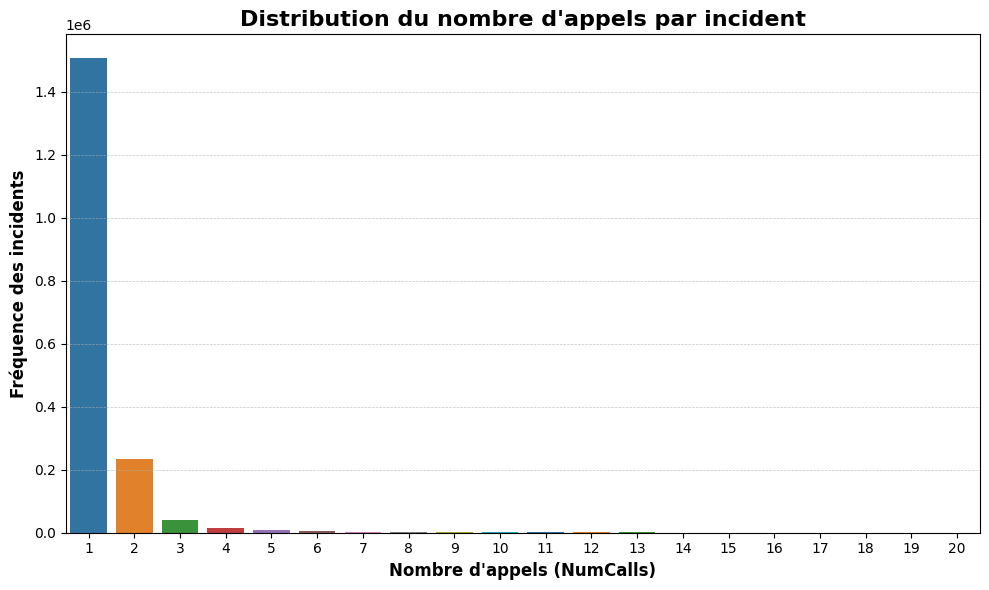

In [6]:
# Analyse de la colonne NumCalls pour determiner les appels pour chaque incident:
# Analyse des valeurs uniques de NumCalls
print("Valeurs uniques dans NumCalls :")
print(df["NumCalls"].unique())

# on r√©initialise l‚Äôindex SANS toucher au df original
num_df = df[df['NumCalls'] <= 20].reset_index(drop=True)

# ordre des barres : du plus fr√©quent au moins fr√©quent
order = num_df['NumCalls'].value_counts().index 

# Distribution de NumCalls
plt.figure(figsize=(10, 6))
sns.countplot(data=num_df, x='NumCalls', order=order, palette='tab10')
plt.title("Distribution du nombre d'appels par incident", fontsize=16, fontweight='bold')
plt.xlabel("Nombre d'appels (NumCalls)", fontsize=12, fontweight='bold')
plt.ylabel("Fr√©quence des incidents", fontsize=12, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

Environ 90‚Äì95‚ÄØ% (visuellement estim√©) des incidents ne sont associ√©s qu‚Äô√† un seul appel !
Cela sugg√®re que pour la plupart des situations, un seul appel suffit √† d√©clencher l‚Äôintervention ou √† g√©rer l‚Äôincident.

In [7]:
# 1) Lignes o√π NumCalls est manquant
na_calls = df[df["NumCalls"].isna()]
print(f"Nombre de lignes avec NumCalls manquant : {na_calls.shape[0]}")

# 1-a) Y a-t-il plusieurs enregistrements pour le m√™me IncidentNumber ?
dup_incidents = na_calls.duplicated(subset="IncidentNumber").sum()
print(f"Duplications sur IncidentNumber parmi les NA : {dup_incidents}")

# 1-b) Distribution (rapide) d‚Äôautres indicateurs pour comparer aux incidents ¬´ normaux ¬ª
cols_check = ["NotionalCost", "PumpCount", "NumPumpsAttending", "IncidentGroup", "IncidentNumber", "DateOfCall_str", "IncGeo_BoroughName"]
print("\nR√©sum√© stats des colonnes comparatives :")
display(na_calls[cols_check].describe())

# 1-c) Profil des groupes d‚Äôincident
print("\nTop 10 des IncidentGroup pour NA :")
print(na_calls["IncidentGroup"].value_counts().head(10))

Nombre de lignes avec NumCalls manquant : 1849
Duplications sur IncidentNumber parmi les NA : 0

R√©sum√© stats des colonnes comparatives :


NotionalCost  PumpCount  NumPumpsAttending
count        1849.0     1849.0             1793.0
mean       318.4543   1.611141           1.597881
std      530.075481   0.962897           0.778145
min           255.0        1.0                1.0
25%           260.0        1.0                1.0
50%           260.0        1.0                1.0
75%           290.0        2.0                2.0
max         14234.0       16.0                6.0


Top 10 des IncidentGroup pour NA :
IncidentGroup
False Alarm        1319
Fire                327
Special Service     203
Name: count, dtype: Int64


Pas de doublons sur IncidentNumber, Chaque ligne est un incident unique car pas de doublons	
PumpCount ‚â• 1 (min = 1, mean ‚âà 1,6)	Au moins un engin s‚Äôest d√©plac√© ‚Üí il y a eu  donc un vrai appel !	
NotionalCost ‚â• 255 ¬£ (co√ªt > 0 pour toutes)	Un co√ªt est logiquement g√©n√©r√© seulement si l‚Äôappel est valide !
IncidentGroup majoritairement ‚ÄúFalse Alarm‚Äù (71 %)	M√™me pour une fausse alerte, il faut au moins un appel pour d√©clencher l‚Äôintervention

D√©cision: ==>Imputation des NA en 1 

In [8]:
# Traitement des valeurs manquantes dans NumCalls
# 1. Identifier les lignes avec NumCalls manquant:
numcalls_na = df["NumCalls"].isna()

# 2. D√©terminer si l'incident montre une vraie intervention (co√ªt ou engin mobilis√©):
intervention_probable = (
    (df["PumpCount"] > 0) |
    (df["NumPumpsAttending"] > 0) |
    (df["NotionalCost"] > 0)
)

# 3. Imputer 1 appel si une intervention est probable:
df.loc[numcalls_na & intervention_probable, "NumCalls"] = 1

# 4. Pour les rares cas restants, imputer 0:
df["NumCalls"].fillna(0, inplace=True)

# 5. V√©rification:

print("\nDistribution finale des valeurs de NumCalls :")
print(df["NumCalls"].value_counts(dropna=False).sort_index())
# Nombre total de lignes dans NumCalls
nb_lignes_numcalls = df["NumCalls"].shape[0]
print(f"Nombre total de lignes dans NumCalls : {nb_lignes_numcalls}")

# V√©rifie qu'il n'y a plus de NA
print("\nValeurs manquantes dans apres imputation NumCalls :")
print(df["NumCalls"].isna().sum())

# R√©sum√© statistique
print("\nStatistiques descriptives de NumCalls :")
print(df["NumCalls"].describe())


Distribution finale des valeurs de NumCalls :
NumCalls
1      1509185
2       233663
3        39154
4        13688
5         7635
        ...   
144          1
161          1
175          1
210          1
369          1
Name: count, Length: 101, dtype: Int64
Nombre total de lignes dans NumCalls : 1824973

Valeurs manquantes dans apres imputation NumCalls :
0

Statistiques descriptives de NumCalls :
count    1824973.0
mean      1.327474
std       1.486381
min            1.0
25%            1.0
50%            1.0
75%            1.0
max          369.0
Name: NumCalls, dtype: Float64


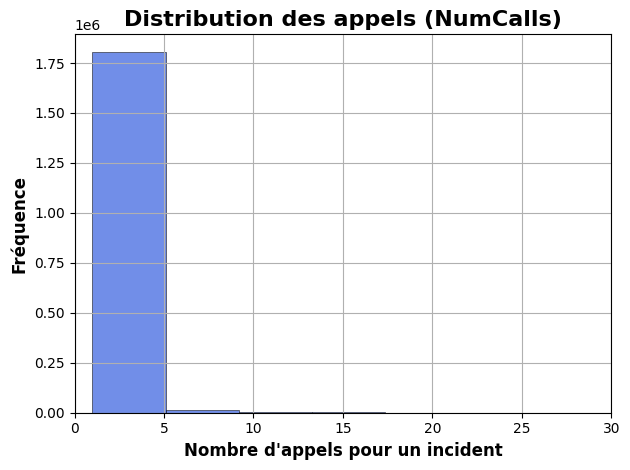

In [9]:
# Histogramme centr√© sur les valeurs les plus courantes des appels
sns.histplot(df["NumCalls"], bins=90, color="royalblue")
plt.xlim(0, 30)  
plt.title("Distribution des appels (NumCalls)", fontsize=16, fontweight='bold')
plt.xlabel("Nombre d'appels pour un incident", fontsize=12, fontweight='bold')
plt.ylabel("Fr√©quence", fontsize=12, fontweight='bold')
plt.grid(True)
plt.tight_layout()
plt.show()

Distribution tr√®s d√©s√©quilibr√©e:
La quasi-totalit√© des incidents sont associ√©s √† tr√®s peu d'appels (typiquement entre 1 et 5)


- Etude de appels par diff√©rentes dimensions
 taille: Hourly : (142416, 15) | Daily : (5934, 15) | Weekly : (849, 15) | Monthly : (195, 15) | Yearly : (17, 15)


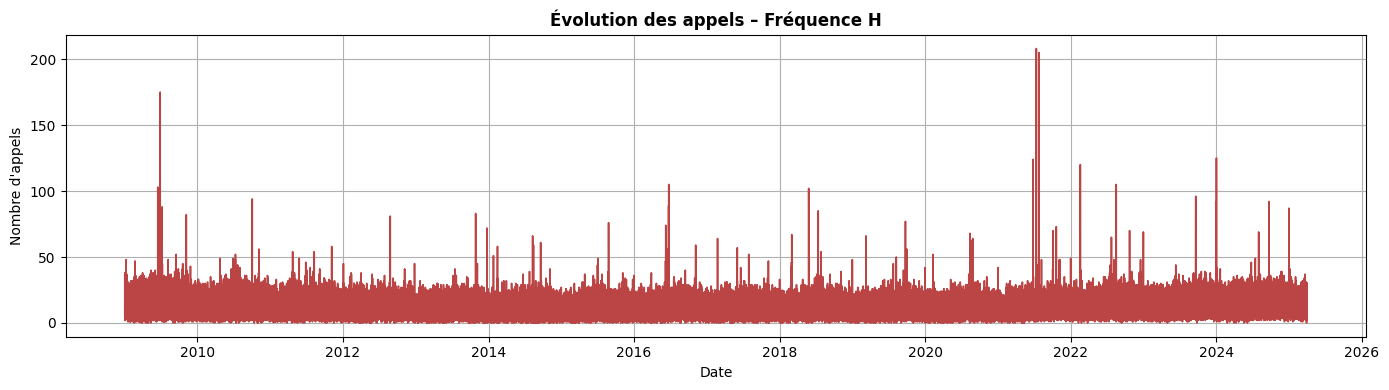

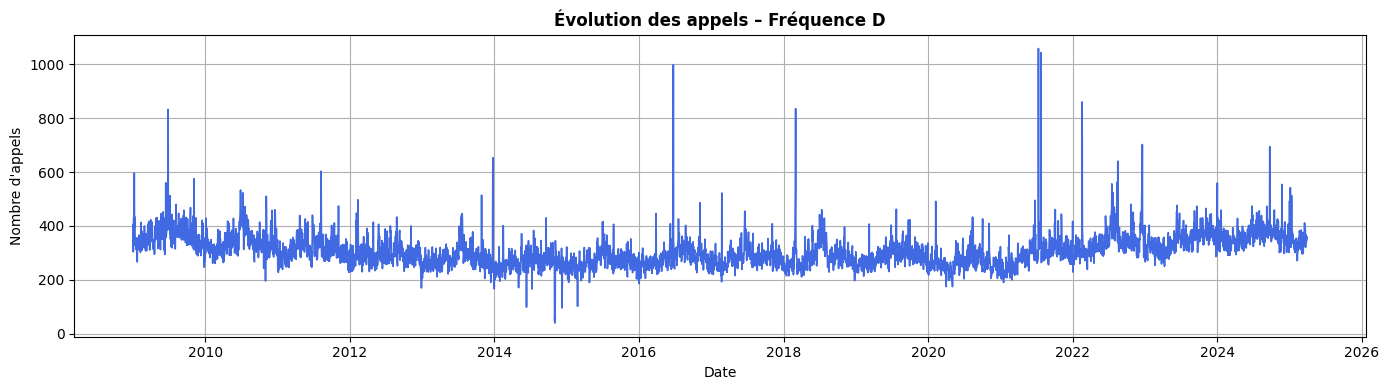

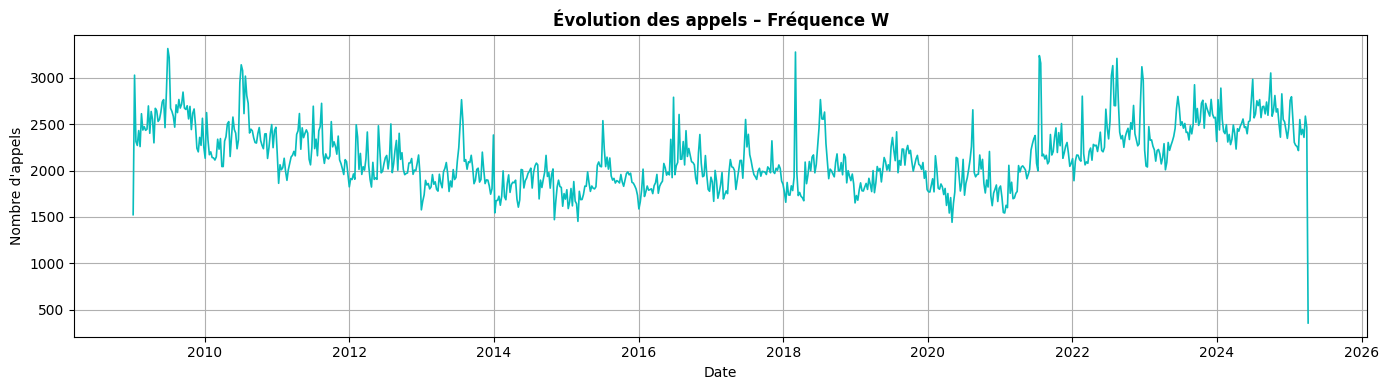

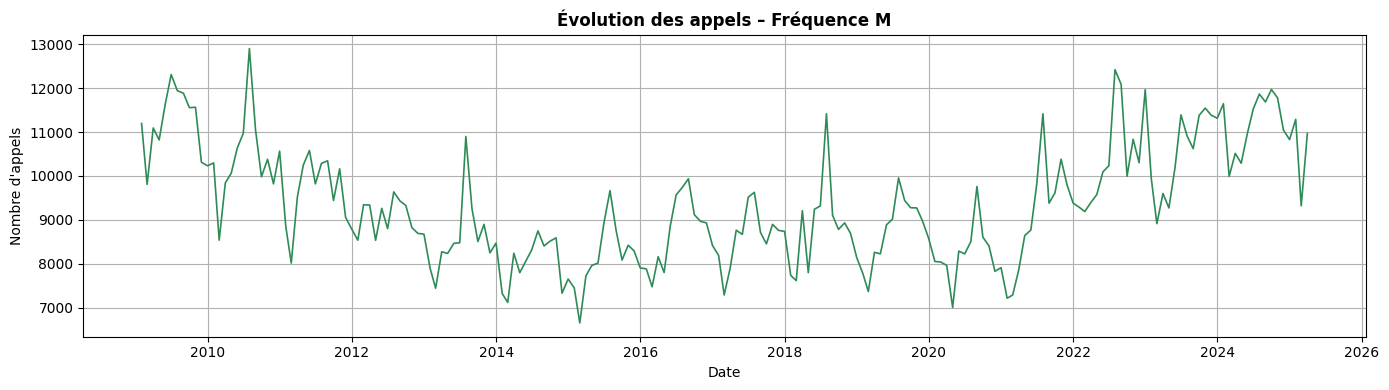

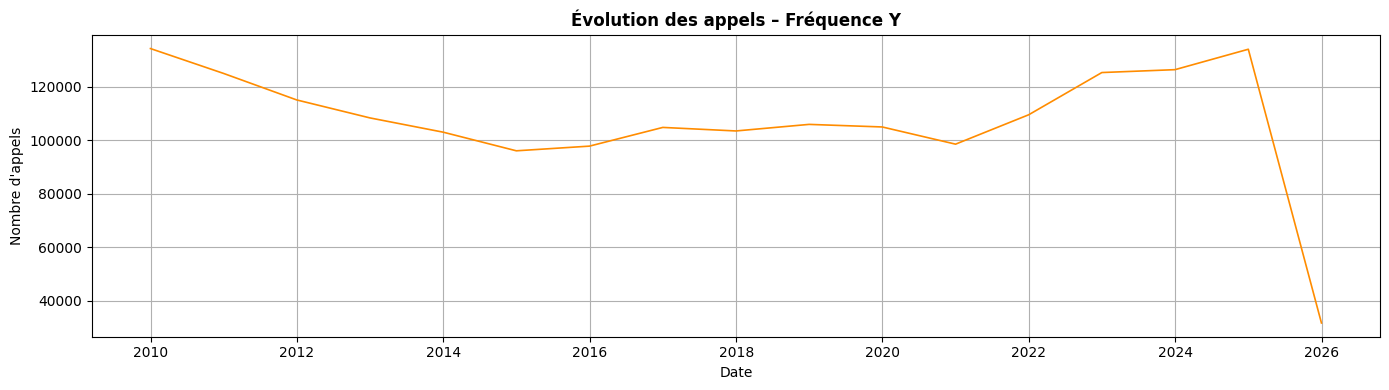

weekday  hour  NumCalls_count  NumCalls_sum  NumCalls_mean  \
0        0     0            7719         11166        1.44656   
1        0     1            6447          9419        1.46099   
2        0     2            5238          7772       1.483772   
3        0     3            4474          6533       1.460215   
4        0     4            4063          5463       1.344573   

   NotionalCost_count  NotionalCost_sum  NotionalCost_mean  PumpCount_count  \
0                7719           3155218         408.759943             7719   
1                6447           2917203         452.489995             6447   
2                5238           2791527         532.937572             5238   
3                4474           1976614         441.800179             4474   
4                4063           1820540         448.077775             4063   

   PumpCount_sum  PumpCount_mean  NumPumpsAttending_count  \
0          12483        1.617178                     7665   
1          10462         1.62277                     6380   
2           8805        1.680985                     5152   
3           7305        1.632767                     4374   
4           6713        1.652227                     3998   

   NumPumpsAttending_sum  NumPumpsAttending_mean  \
0                  12072                1.574951   
1                   9985                1.565047   
2                   8225                1.596467   
3                   6970                1.593507   
4                   6375                1.594547   

   NumStationsWithPumpsAttending_count  NumStationsWithPumpsAttending_sum  \
0                                 7665                              10425   
1                                 6380                               8584   
2                                 5152                               7045   
3                                 4374                               6003   
4                                 3998                               5496   

   NumStationsWithPumpsAttending_mean  
0                            1.360078  
1                            1.345455  
2                             1.36743  
3                            1.372428  
4                            1.374687

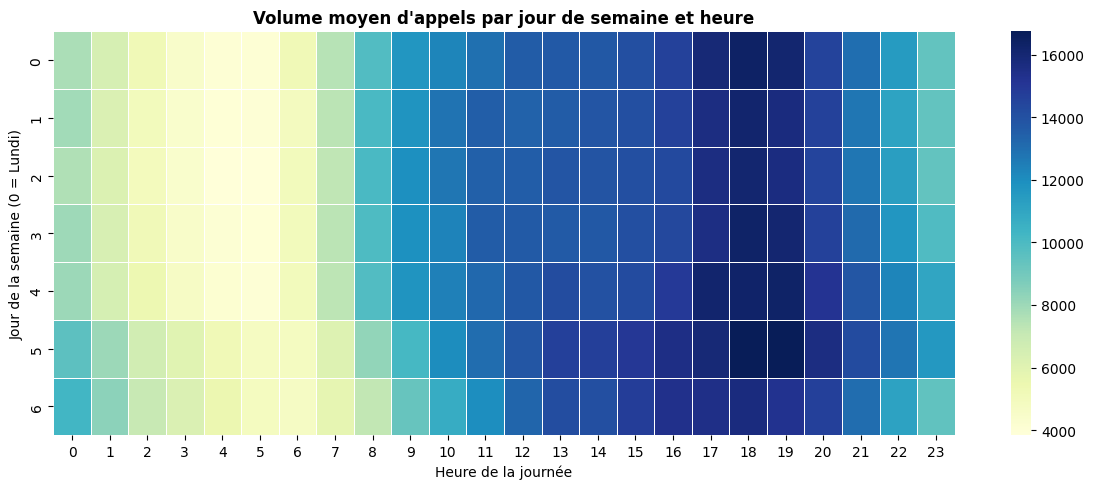

In [10]:
# Etude de appels par differentes dimensions
print("\n- Etude de appels par diff√©rentes dimensions")
# Enrichissement calendaire
df = df.assign(
    year=df.index.year,
    quarter=df.index.quarter,
    month=df.index.month,
    week=df.index.isocalendar().week,
    weekday=df.index.dayofweek,  # 0 = lundi
    day=df.index.day,
    hour=df.index.hour
).astype({
    "year": "Int64", "quarter": "Int64", "month": "Int64", "week": "Int64",
    "weekday": "Int64", "day": "Int64", "hour": "Int64"
})

# Fonctions d'agr√©gation
NUM_COLS = ["NumCalls", "NotionalCost", "PumpCount", "NumPumpsAttending", "NumStationsWithPumpsAttending"]
DEFAULT_FUNCS = ["count", "sum", "mean"]

def aggregate_by_time(freq="D", columns=NUM_COLS, funcs=DEFAULT_FUNCS):
    """ Agr√®ge les colonnes num√©riques par fr√©quence temporelle """
    agg_map = {col: funcs for col in columns}
    df_ts = df.resample(freq).agg(agg_map)
    df_ts.columns = [f"{col}_{func}" for col, func in df_ts.columns.to_flat_index()]
    return df_ts


def aggregate_by_dimensions(dims=("weekday", "hour"), columns=NUM_COLS, funcs=DEFAULT_FUNCS, dropna=True):
    """ Cube multi-index pour analyses crois√©es temporelles """
    agg_map = {col: funcs for col in columns}
    df_cube = df.groupby(list(dims)).agg(agg_map).reset_index()
    df_cube.columns = ["_".join(map(str, col)).strip("_") for col in df_cube.columns]
    return df_cube.dropna(how="all", axis=1) if dropna else df_cube

# Fonction de visualisation
def plot_timeseries(data, freq_label, color, y_col="NumCalls_count"):
    plt.figure(figsize=(14, 4))
    plt.plot(data.index, data[y_col], color=color, linewidth=1.2)
    plt.title(f"√âvolution des appels ‚Äì Fr√©quence {freq_label}", fontweight="bold")
    plt.xlabel("Date")
    plt.ylabel("Nombre d'appels")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Agr√©gations temporelles
df_hourly  = aggregate_by_time("H")
df_daily   = aggregate_by_time("D")
df_weekly  = aggregate_by_time("W")
df_monthly = aggregate_by_time("M")
df_yearly  = aggregate_by_time("Y")

print(" taille: Hourly :", df_hourly.shape, "| Daily :", df_daily.shape, "| Weekly :", df_weekly.shape, "| Monthly :", df_monthly.shape, "| Yearly :", df_yearly.shape)

# Visualisation des s√©ries temporelles=
COLOR_MAP = {"H": "#BB4545", "D": "royalblue", "W": "#08bdbd", "M": "seagreen", "Y": "darkorange"}

for label, data in [("H", df_hourly), ("D", df_daily), ("W", df_weekly), ("M", df_monthly), ("Y", df_yearly)]:
    plot_timeseries(data, label, COLOR_MAP[label])

# Cube Jour de Semaine x Heure
cube_weekday_hour = aggregate_by_dimensions(("weekday", "hour"))
display(cube_weekday_hour.head())

#Heatmap par heure et jour de semaine
heatmap_data = cube_weekday_hour.pivot(index="weekday", columns="hour", values="NumCalls_count").fillna(0)

plt.figure(figsize=(12, 5))
sns.heatmap(heatmap_data.astype(float), cmap="YlGnBu", linewidths=0.5)
plt.title("Volume moyen d'appels par jour de semaine et heure", fontweight="bold")
plt.xlabel("Heure de la journ√©e")
plt.ylabel("Jour de la semaine (0 = Lundi)")
plt.tight_layout()
plt.show()

Observation sur les differentes granularit√© d'√©volution des appels:

Plus on s‚Äô√©loignes dans le temps (H ‚Üí D ‚Üí W ‚Üí M‚ÜíY), plus on gagnes en lisibilit√© de la tendance :   
-"Evolution des appels-Fr√©quence H" => √Ä l‚Äôheure : bruit, √©v√©nements extr√™mes
-"Evolution des appels-Fr√©quence D" => Au jour : stabilisation avec pics visibles
-"Evolution des appels-Fr√©quence W" => √Ä la semaine : cycles liss√©s
-"Evolution des appels-Fr√©quence M" => Au mois : tendance globale, saisonnalit√© tr√®s lisible
-"√âvolution des appels ‚Äì Fr√©quence Annuelle Y" => √† l'ann√©e: 
2009-2015 : D√©clin net du nombre d'appels, avec une perte d‚Äôenviron 25% du volume initial.
2016-2020 : Phase de stabilisation entre 95k et 105k appels/an, avec de petites fluctuations sans tendance claire.
2021-2024 : Reprise forte et continue, le nombre d'appels repart √† la hausse et d√©passe le niveau de 2009.
2025 (partiel) : Chute brutale uniquement due au fait que les donn√©es s'arr√™tent au 31 mars 2025. Cette baisse n‚Äôa rien d‚Äôop√©rationnel, elle est due √† l‚Äôabsence de donn√©es compl√®tes.

La granularit√© hebdo ou mensuelle/annuelle semble la plus pertinente pour anticiper la charge.

Synth√®se de la Heatmap:
Volume moyen d'appels par jour de la semaine et heure
Ce qu‚Äôon observe :
Les appels sont surtout concentr√©s en journ√©e, entre 8h et 20h. C‚Äôest vraiment en fin d‚Äôapr√®s-midi, entre 16h30 et 19h, que l‚Äôon constate le plus gros pic d‚Äôactivit√©! Mardi etant le jour avec le plus grand nombre d'appels independament de l'heure d'appel
La r√©partition est plut√¥t stable du lundi au dimanche

| P√©riode    | Volume d‚Äôappels | Commentaire                         |
| ---------- | --------------- | ----------------------------------- |
| 2009-2014  | En baisse       | R√©duction progressive d‚Äôactivit√©    |
| 2015-2020  | Stable          | Activit√© consolid√©e                 |
| 2021-2024  | En hausse       | Reprise importante                  |
| Apr√®s 2024 | Forte chute     | 3 mois de datas 2025 insuffisant    |
|            |                 | pour observ√© une tendence annuelle  |

<span style="color:#e91e63; font-size:1em; font-weight:bold;">6- Analyse de la r√©partition et √©volution des incidents: jour, mois, heure, ann√©e   </span>

In [11]:
#v√©rification de l'index:
df["DateTime"] = df.index
print("Type d'index :", type(df.index))
print("Nom de l'index :", df.index.name)

Type d'index : <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Nom de l'index : DateTime



Shapes des s√©ries :
Hourly : (142416,)
Daily  : (5934,)
Weekly : (849,)
Monthly: (195,)
Yearly : (17,)


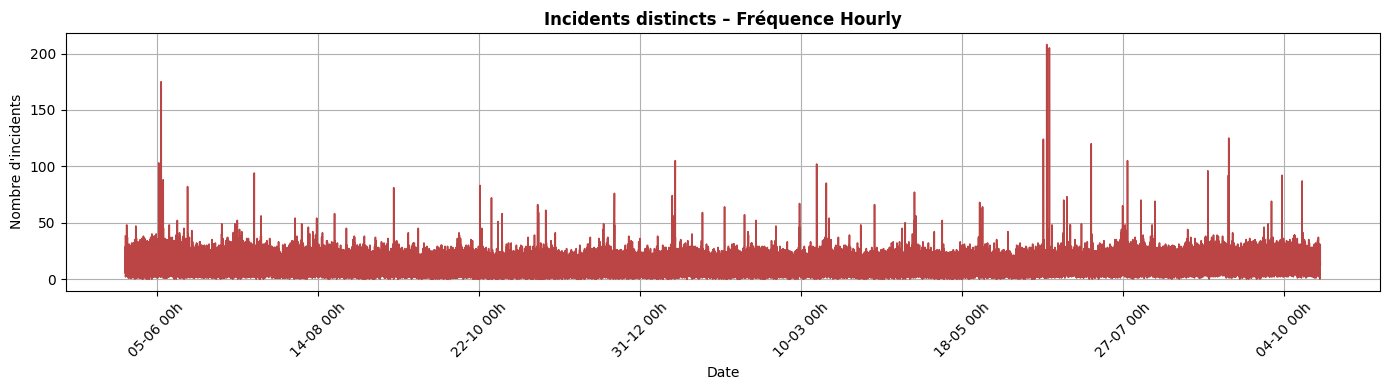

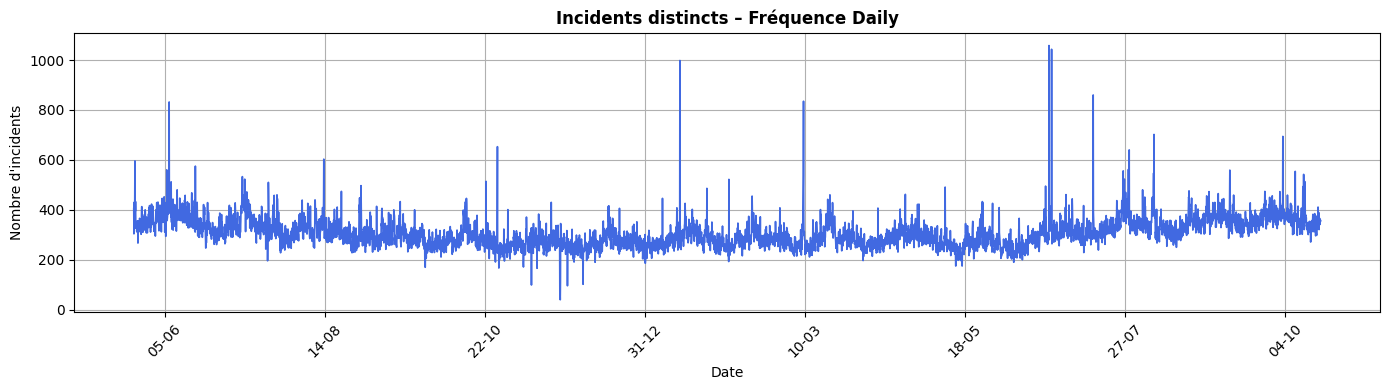

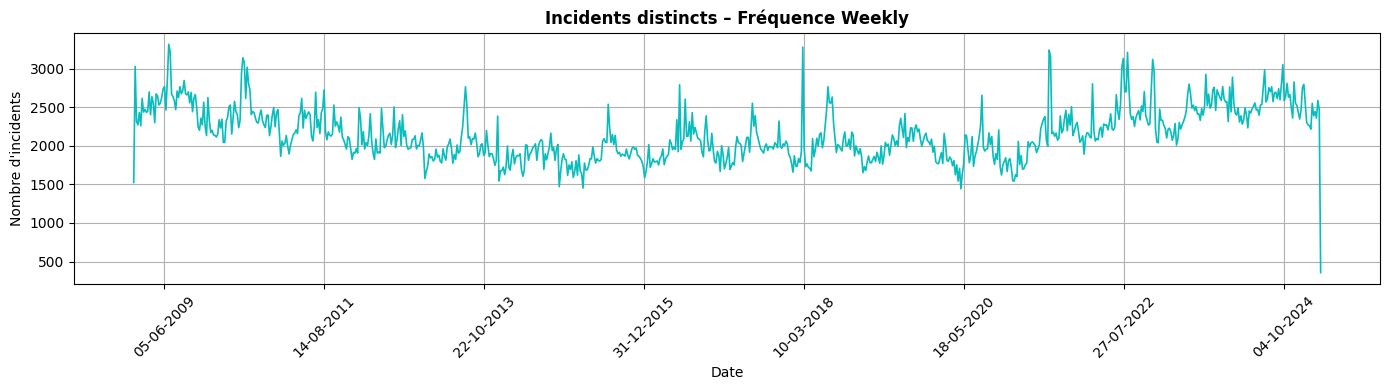

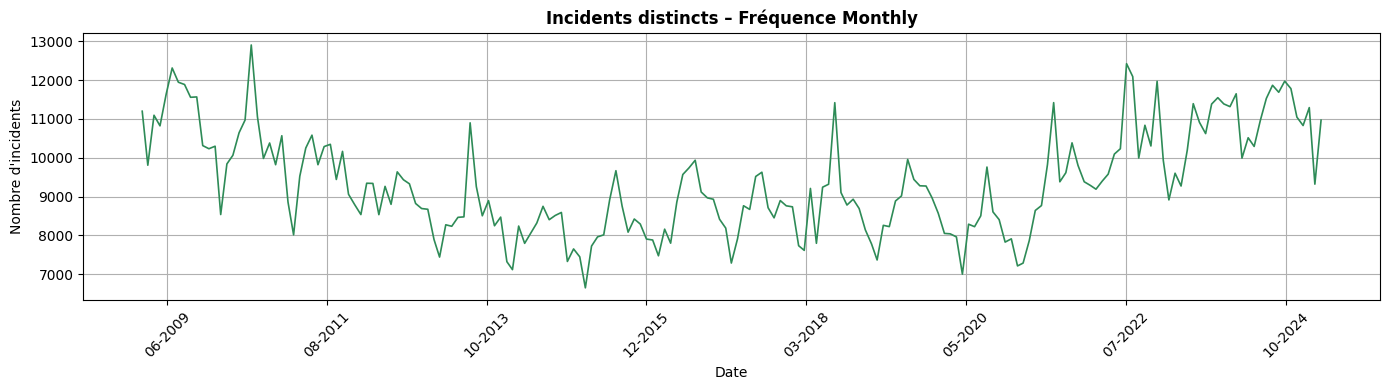

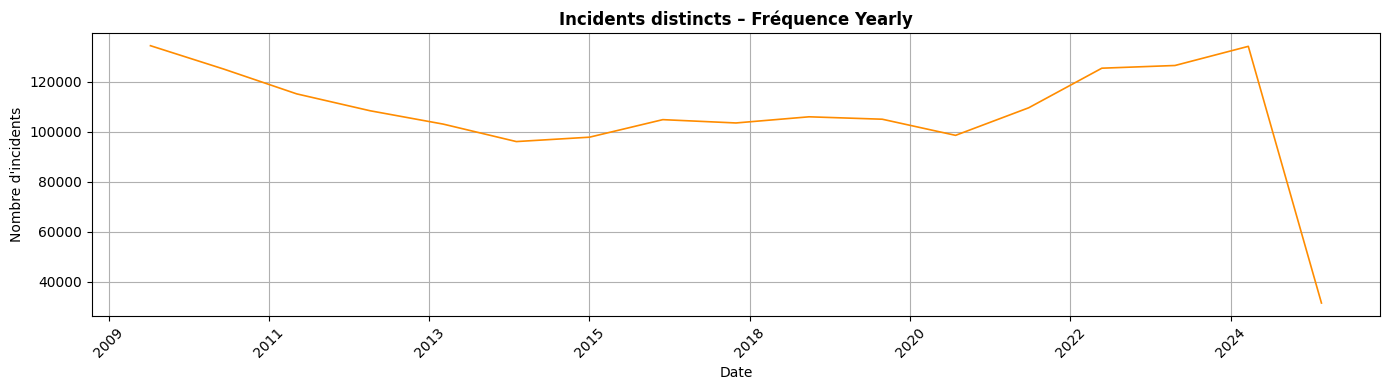

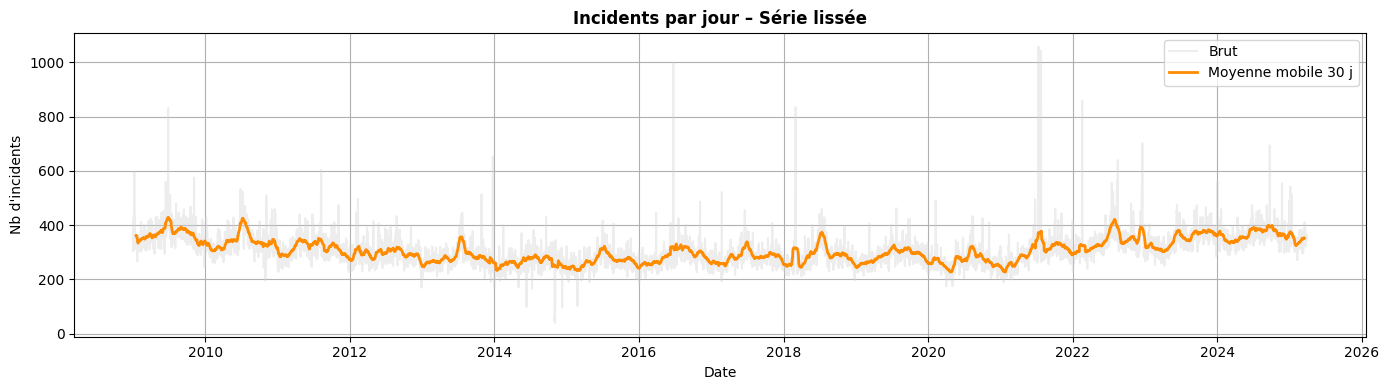

In [12]:
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator

# 1Ô∏è‚É£ Fonction d'agr√©gation unique
def incidents_ts(df, freq="D"):
    return df.resample(freq)["IncidentNumber"].nunique().rename("incident_count")

# 2Ô∏è‚É£ S√©ries par fr√©quence
frequencies = {
    "Hourly": "H",
    "Daily": "D",
    "Weekly": "W",
    "Monthly": "M",
    "Yearly": "Y"
}
series_dict = {label: incidents_ts(df, freq) for label, freq in frequencies.items()}

# V√©rification des tailles
print("\nShapes des s√©ries :")
for label, serie in series_dict.items():
    print(f"{label:<7}: {serie.shape}")

# 3Ô∏è‚É£ Visualisations homog√®nes
COLOR = {
    "Hourly": "#BB4545",
    "Daily": "royalblue",
    "Weekly": "#08bdbd",
    "Monthly": "seagreen",
    "Yearly": "darkorange"
}

date_format = {
    "Hourly": mdates.DateFormatter('%d-%m %Hh'),
    "Daily": mdates.DateFormatter('%d-%m'),
    "Weekly": mdates.DateFormatter('%d-%m-%Y'),
    "Monthly": mdates.DateFormatter('%m-%Y'),
    "Yearly": mdates.DateFormatter('%Y')
}

for label, serie in series_dict.items():
    plt.figure(figsize=(14, 4))
    plt.plot(serie.index, serie, color=COLOR[label], linewidth=1.2)
    plt.title(f"Incidents distincts ‚Äì Fr√©quence {label}", fontweight="bold")
    plt.xlabel("Date")
    plt.ylabel("Nombre d'incidents")
    plt.grid(True)

    ax = plt.gca()
    ax.xaxis.set_major_formatter(date_format[label])
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# 4Ô∏è‚É£ Lissage mobile (version plus claire)
window = 30
inc_daily = series_dict["Daily"]
inc_daily_smooth = inc_daily.rolling(window=window, center=True).mean()

plt.figure(figsize=(14, 4))
plt.plot(inc_daily, color="lightgrey", alpha=0.4, label="Brut")
plt.plot(inc_daily_smooth, color="darkorange", linewidth=2, label=f"Moyenne mobile {window} j")
plt.title("Incidents par jour ‚Äì S√©rie liss√©e", fontweight="bold")
plt.xlabel("Date")
plt.ylabel("Nb d'incidents")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Observation:
Horaire (H)	Tr√®s granulaire. Des pics exceptionnels (vers 2022).
Journalier (D)	Densit√© tr√®s forte, tr√®s bonne base pour analyse saisonni√®re.
Hebdo (W)	Les cycles plus larges sont visibles ; utile pour d√©tecter baisses structurelles.
Mensuel (M)	Super clair : on voit un effondrement des donn√©es en 2024‚Äì2025 car les donn√©es s'arrettent au 31/03/2025.


##  **Conclusion :**
* Les courbes li√©es a `IncidentNumber` et `NumCalls` montrent la **m√™me dynamique √† toutes les fr√©quences**.
* On peux **choisir l‚Äôune ou l‚Äôautre colonne pour la mod√©lisation** selon l'objectif :

  * **NumCalls** : Volume d‚Äôappels, plus lisible m√©tier.
  * **IncidentNumber** : Compte distinct des √©v√®nements.

**Les deux variables sont bien corr√©l√©es.**

 <span style="color:#e91e63; font-size:1em; font-weight:bold;"> 7- D√©composition saisonni√®res ( additive/multiplicative) </span>

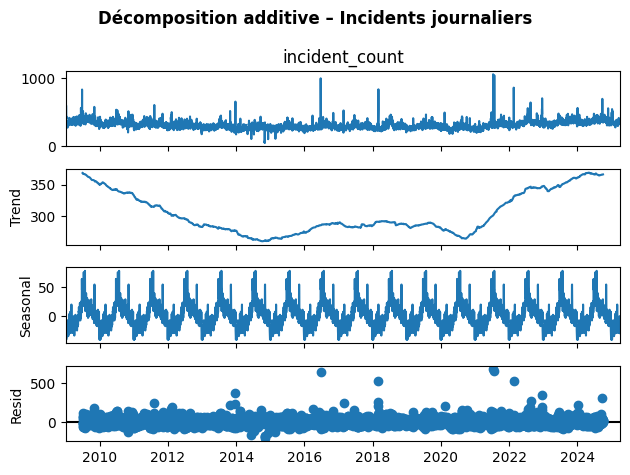

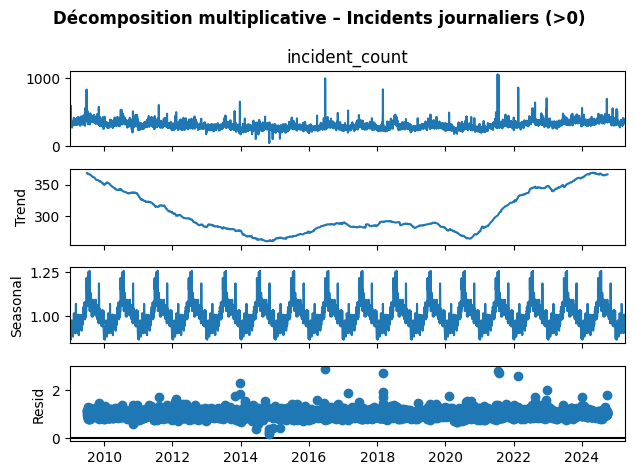

In [13]:
# 5. D√©compositions saisonni√®res
from statsmodels.tsa.seasonal import seasonal_decompose

# a) Additive
decomp = seasonal_decompose(inc_daily, model="additive", period=365)
decomp.plot()
plt.suptitle("D√©composition additive ‚Äì Incidents journaliers", fontweight="bold")
plt.tight_layout()
plt.show()

# b) Multiplicative
inc_daily_nonzero = inc_daily[inc_daily > 0]
decomp_mult = seasonal_decompose(inc_daily_nonzero, model="multiplicative", period=365)
decomp_mult.plot()
plt.suptitle("D√©composition multiplicative ‚Äì Incidents journaliers (>0)", fontweight="bold")
plt.tight_layout()
plt.show()

## **D√©composition Additive : Incidents Journaliers**

### Ce que l'on remarque :

* **Tendance (Trend)** : Elle montre une baisse progressive des incidents entre 2010 et 2015, suivie d'une lente remont√©e jusqu'√† 2024. C'est tr√®s lisible.
* **Saisonnalit√© (Seasonal)** : Elle est fixe dans l'additif : la m√™me amplitude est conserv√©e tout au long de la s√©rie. Cela signifie que le mod√®le suppose que les variations saisonni√®res (pics et creux) sont constantes dans le temps, quelles que soient les √©volutions de la tendance.
* **R√©sidus (Resid)** : On voit des points atypiques (outliers) assez marqu√©s, surtout vers la fin. Cela signifie que certains jours ont des valeurs tr√®s √©loign√©es de ce qu‚Äôexpliquerait la tendance et la saisonnalit√© seule.

### En r√©sum√© :

La d√©composition **additive** est adapt√©e quand l'effet saisonnier est suppos√© constant au fil des ans. On voit des fluctuations d'ampleur similaire m√™me quand la tendance change.


## **D√©composition Multiplicative : Incidents Journaliers (>0)**

### Ce que l'on remarque :

* **Tendance (Trend)** : Elle suit le m√™me sch√©ma g√©n√©ral que l'additive, mais avec des valeurs transform√©es (plus proches de proportions ou rapports que de quantit√©s brutes).
* **Saisonnalit√© (Seasonal)** : Ici, elle est relative : on voit qu'elle oscille autour de 1 (pas autour d'une valeur fixe) et son effet est proportionnel au niveau de la tendance. Quand la tendance est basse, l'effet saisonnier est faible, et inversement.
* **R√©sidus (Resid)** : Ils semblent plus homog√®nes, ce qui est normal car les effets disproportionn√©s sont "absorb√©s" par la multiplicativit√©. Mais des jours atypiques subsistent.

### En r√©sum√© :

La d√©composition **multiplicative** suppose que les effets saisonniers sont proportionnels au niveau g√©n√©ral des incidents. On voit ici que c‚Äôest plus pertinent dans les p√©riodes o√π le volume change fortement : l‚Äôamplitude saisonni√®re est r√©duite quand l‚Äôactivit√© est faible, et amplifi√©e quand elle est forte.



## **Comparaison g√©n√©rale:**

|                         | **Additive**                   | **Multiplicative**           |
| ----------------------- | ------------------------------ | ---------------------------- |
| **Saisonnalit√©**        | Constante                      | Proportionnelle au niveau    |
| **Lecture des r√©sidus** | R√©sidus parfois tr√®s dispers√©s | R√©sidus plus homog√®nes       |
| **√Ä privil√©gier si...** | Effets saisonniers fixes       | Effets saisonniers √©volutifs |

---

## **D√©cision pour la suite :**

Pour **comparer des tendances de fond sur de longues p√©riodes**, l'additif est plus facile √† interpr√©ter.
Pour **mod√©liser des s√©ries o√π les variations saisonni√®res varient avec le volume**, la multiplicative est plus pertinente.

Dans ce cas, vu les fortes diff√©rences d‚Äôactivit√© (2014, 2017, 2023...), **la multiplicative semble plus robuste** car elle s‚Äôadapte mieux aux changements de niveau d‚Äôactivit√©.

Nous avons d√©cid√© de pousser plus loin avec une STL qui combine les avantages des deux d√©compostion.


 <span style="color:#e91e63; font-size:1em; font-weight:bold;"> 8- Test de saisonnalit√© et autocorrelation  ( additive/multiplicative) </span>

In [14]:
#  6. Test de stationnarit√© (ADF):  
def adf_test(series):
    """ Faire le test de Dickey-Fuller augment√© (ADF) pour v√©rifier la stationnarit√©."""
    result = adfuller(series)
    p_value = result[1]
    is_stationary = p_value < 0.05
    return p_value, is_stationary
# Test sur la s√©rie journali√®re
p_value, is_stationary = adf_test(inc_daily)
print(f"Test ADF sur la s√©rie journali√®re : p-value = {p_value:.4f}, la s√©rie est-elle bien stationnaire ? {is_stationary}")


#  7. Autocorr√©lation et autocorr√©lation partielle:
def plot_acf_pacf(series, lags=50):
    """ Afficher les graphiques ACF et PACF"""
    fig, ax = plt.subplots(1, 2, figsize=(16, 5))
    plot_acf(series, lags=lags, ax=ax[0], title="ACF (Autocorr√©lation)")
    plot_pacf(series, lags=lags, ax=ax[1], title="PACF (Autocorr√©lation partielle)")
    plt.tight_layout()
    plt.show()

Test ADF sur la s√©rie journali√®re : p-value = 0.0003, la s√©rie est-elle bien stationnaire ? True


In [15]:
print("Derni√®re date de donn√©es :", df["DateOfCall"].max())

Derni√®re date de donn√©es : 2025-03-31 00:00:00


 <span style="color:#e91e63; font-size:1em; font-weight:bold;"> 9-D√©composition STL</span>

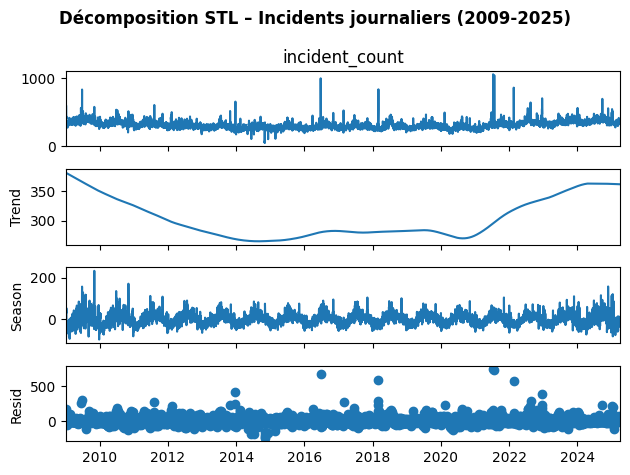

In [16]:
from statsmodels.tsa.seasonal import STL

# On recr√©e la s√©rie quotidienne propre √† partir du DataFrame index√©
# Ici on suppose que 'IncidentNumber' est bien en index 'DateOfCall' d√©j√† et que la colonne IncidentNumber est propre
inc_daily = df.resample('D')["IncidentNumber"].nunique().rename("incident_count")

# Application de la STL
stl = STL(inc_daily, period=365, robust=True)
res_stl = stl.fit()

# Visualisation
fig = res_stl.plot()
fig.suptitle("D√©composition STL ‚Äì Incidents journaliers (2009-2025)", weight='bold')
plt.tight_layout()
plt.show()

Observation sur la d√©composition STL :
Cette d√©composition STL est bien plus souple que les pr√©c√©dentes.
On remarque que :

La tendance est liss√©e proprement, et suit bien l‚Äô√©volution globale sur 2009-2025, avec une baisse puis une lente remont√©e.

La saisonnalit√© est plus r√©aliste ici : elle varie en intensit√© et n‚Äôest pas fig√©e. Cependant, on voit qu‚Äôelle capte des irr√©gularit√©s plus violentes (pics positifs et n√©gatifs importants), probablement des √©v√©nements exceptionnels dans la s√©rie ( covid, ...).

Les r√©sidus sont plus propres et plus centr√©s, mais il reste des jours tr√®s atypiques.

** En r√©sum√©:**
La STL fait un meilleur travail pour d√©tecter la vraie tendance et les irr√©gularit√©s cach√©es, surtout sur une s√©rie aussi instable et longue. Mais elle confirme que la s√©rie reste tr√®s bruit√©e.

  <span style="color:royalblue; font-size:1em; font-weight:bold;"> Comparatif des 3 d√©compositions: </span>

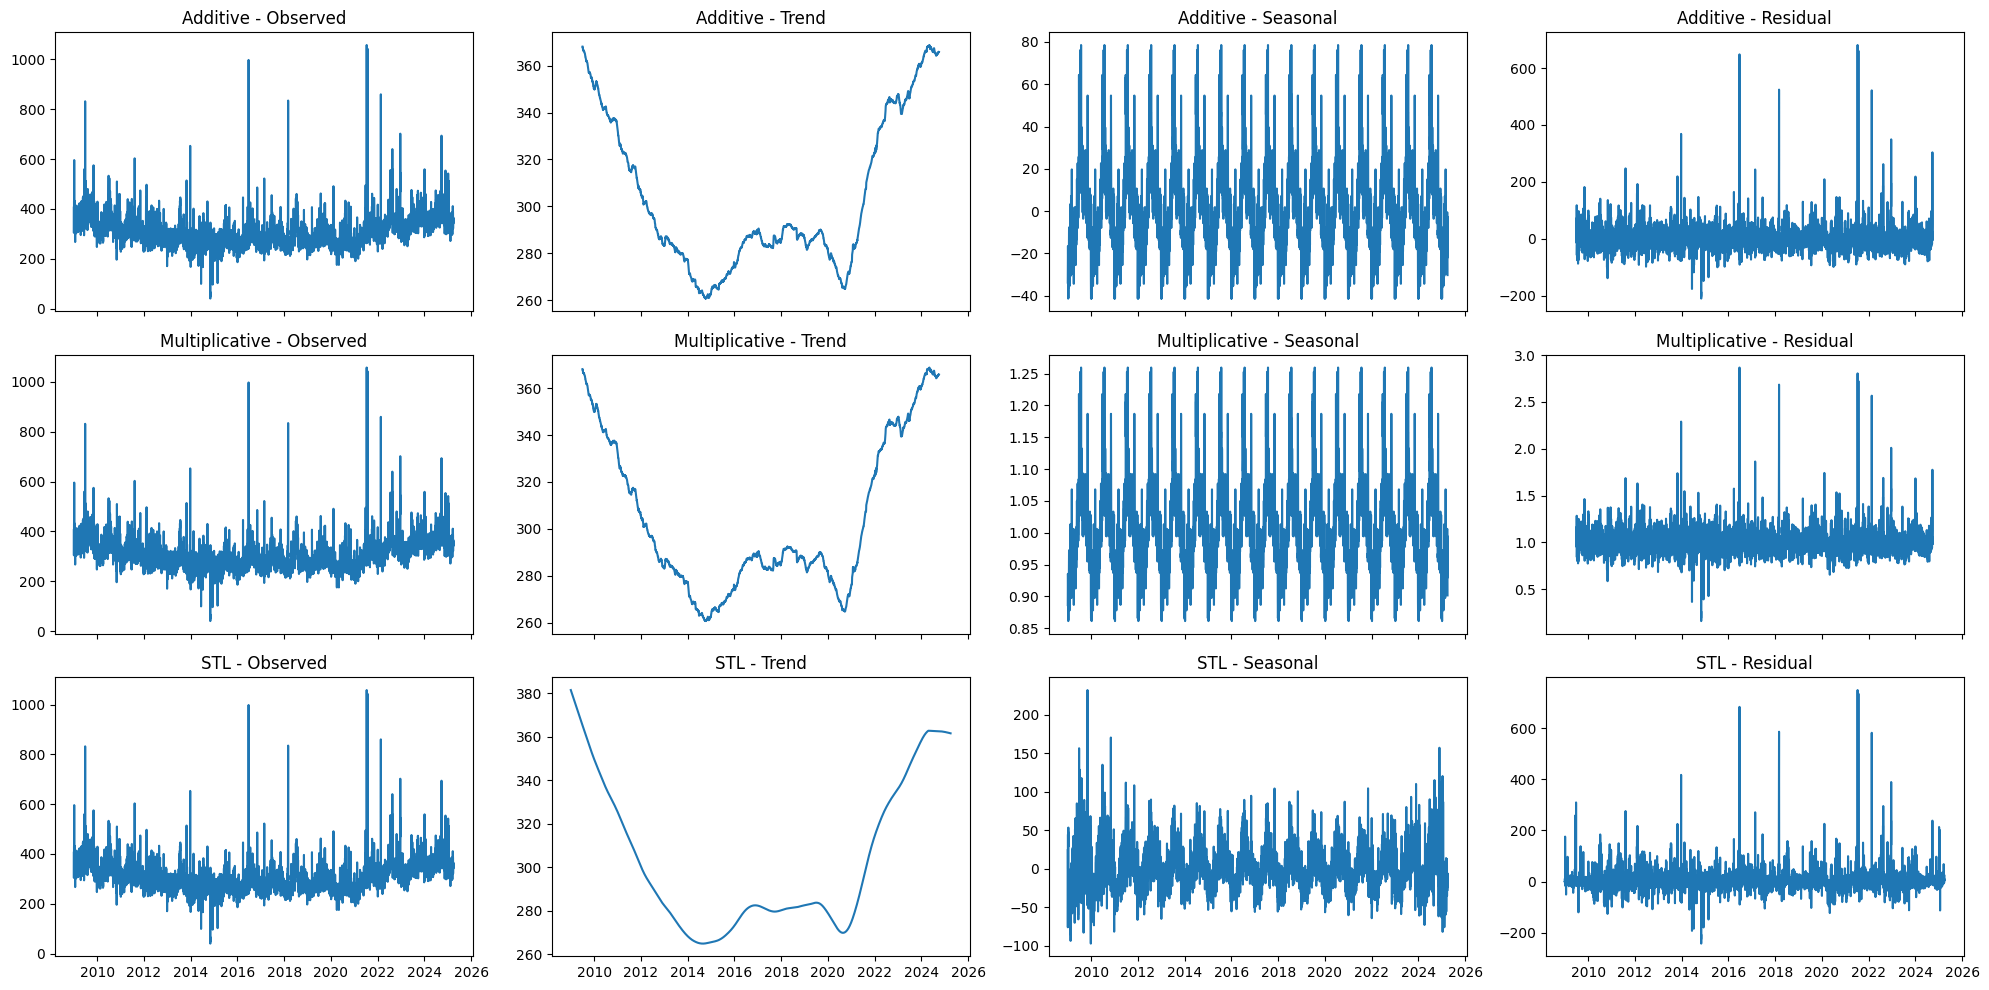

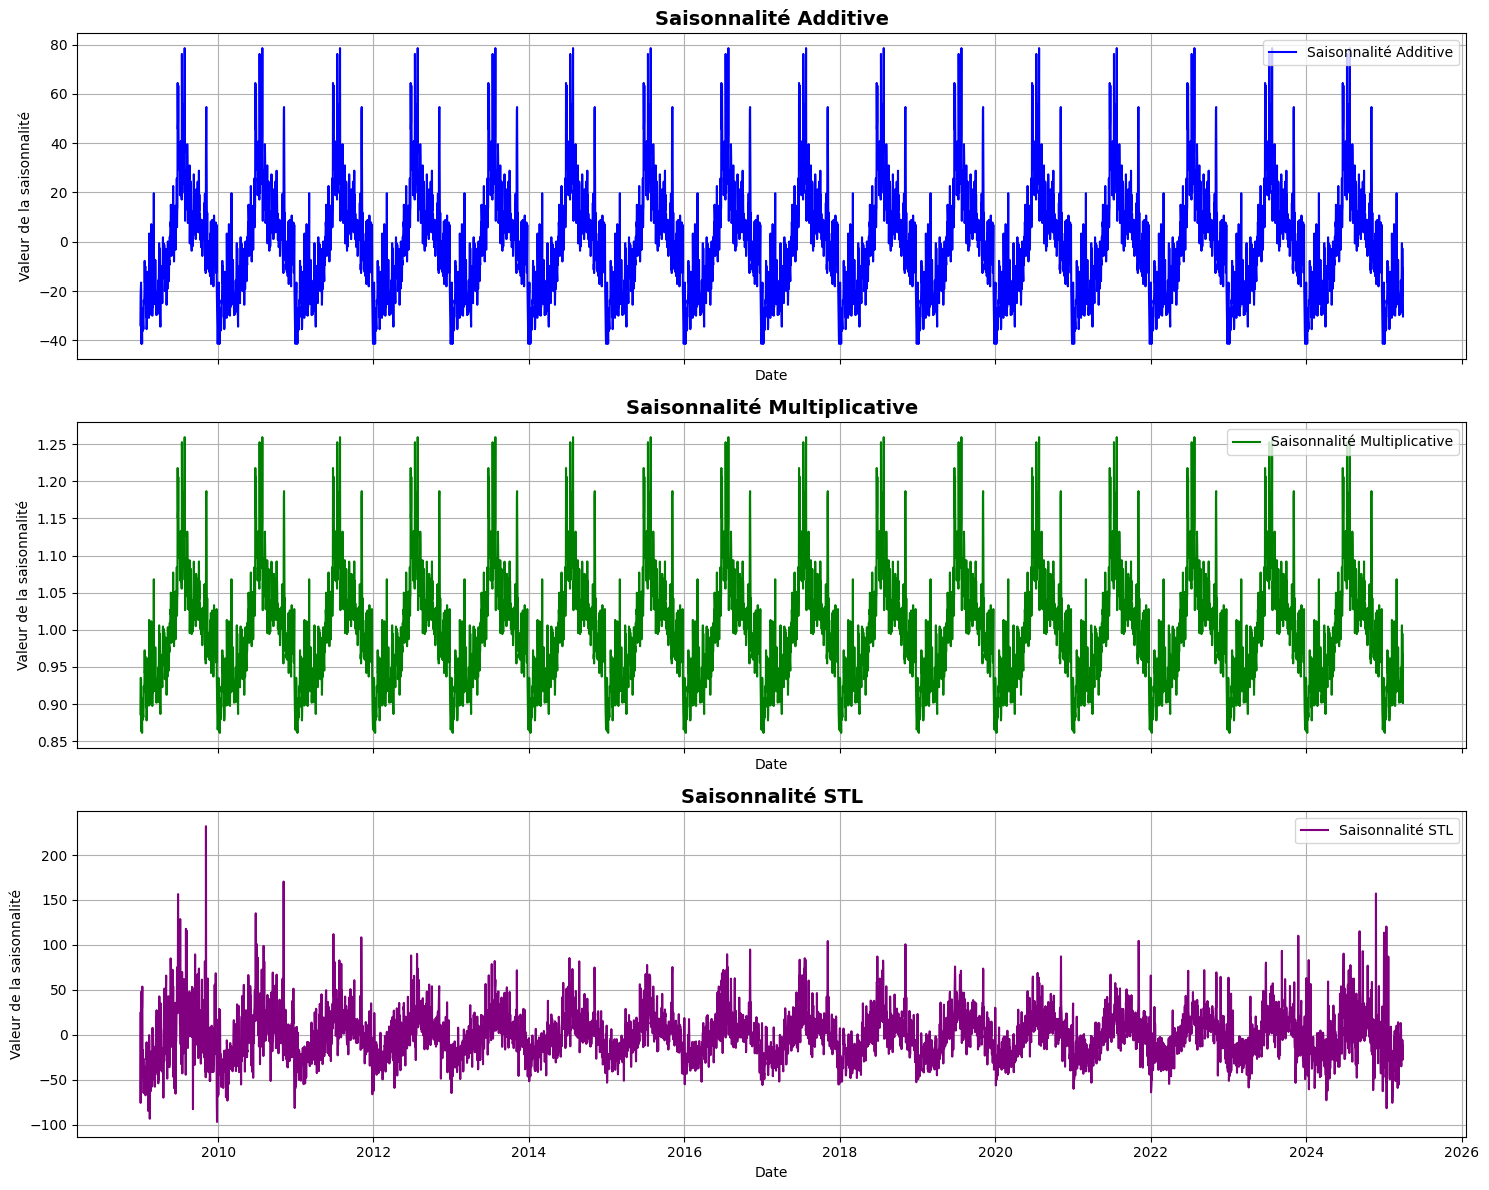

In [17]:
# D√©composition Additive
decomp_add = seasonal_decompose(inc_daily, model="additive", period=365)

# D√©composition Multiplicative
inc_daily_nonzero = inc_daily[inc_daily> 0]
decomp_mult = seasonal_decompose(inc_daily_nonzero, model="multiplicative", period=365)

# D√©composition STL
stl = STL(inc_daily, period=365, robust=True)
res_stl = stl.fit()

# Affichage comparatif des composantes
fig, axes = plt.subplots(3, 4, figsize=(20, 10), sharex=True)

# Additive
axes[0, 0].plot(decomp_add.observed)
axes[0, 0].set_title('Additive - Observed')
axes[0, 1].plot(decomp_add.trend)
axes[0, 1].set_title('Additive - Trend')
axes[0, 2].plot(decomp_add.seasonal)
axes[0, 2].set_title('Additive - Seasonal')
axes[0, 3].plot(decomp_add.resid)
axes[0, 3].set_title('Additive - Residual')

# Multiplicative
axes[1, 0].plot(decomp_mult.observed)
axes[1, 0].set_title('Multiplicative - Observed')
axes[1, 1].plot(decomp_mult.trend)
axes[1, 1].set_title('Multiplicative - Trend')
axes[1, 2].plot(decomp_mult.seasonal)
axes[1, 2].set_title('Multiplicative - Seasonal')
axes[1, 3].plot(decomp_mult.resid)
axes[1, 3].set_title('Multiplicative - Residual')

# STL
axes[2, 0].plot(res_stl.observed)
axes[2, 0].set_title('STL - Observed')
axes[2, 1].plot(res_stl.trend)
axes[2, 1].set_title('STL - Trend')
axes[2, 2].plot(res_stl.seasonal)
axes[2, 2].set_title('STL - Seasonal')
axes[2, 3].plot(res_stl.resid)
axes[2, 3].set_title('STL - Residual')

plt.tight_layout()
plt.show()

# Comparatif de la composante saisonni√®re uniquement
fig, axes = plt.subplots(3, 1, figsize=(15, 12), sharex=True)
axes[0].plot(decomp_add.seasonal, label='Saisonnalit√© Additive', color='blue')
axes[0].set_title('Saisonnalit√© Additive', fontsize=14, fontweight='bold')
axes[1].plot(decomp_mult.seasonal, label='Saisonnalit√© Multiplicative', color='green')
axes[1].set_title('Saisonnalit√© Multiplicative', fontsize=14, fontweight='bold')
axes[2].plot(res_stl.seasonal, label='Saisonnalit√© STL', color='purple')
axes[2].set_title('Saisonnalit√© STL', fontsize=14, fontweight='bold')

for ax in axes:
    ax.legend()
    ax.grid(True)
    ax.set_ylabel('Valeur de la saisonnalit√©')
    ax.set_xlabel('Date')

plt.tight_layout()
plt.show()

## **Analyse comparative des d√©compositions temporelles des incidents (2009-2025)**

###  D√©composition Additive

La d√©composition additive suppose que les composantes **tendance, saisonnalit√© et bruit sont ind√©pendantes et se superposent de fa√ßon constante**.
Elle met en √©vidence :

* Une **baisse des incidents jusqu'en 2016**, suivie d'une **remont√©e progressive jusqu'en 2025**.
* Une **saisonnalit√© fixe dans le temps**, peu r√©aliste dans un contexte urbain en √©volution comme Londres.
* Des **r√©sidus importants sur certains jours**, r√©v√©lant des anomalies nettes, probablement li√©es √† des √©v√©nements exceptionnels.

Cette m√©thode est p√©dagogique mais manque de flexibilit√© sur une s√©rie aussi longue.

### D√©composition Multiplicative

La d√©composition multiplicative suppose que **les effets saisonniers sont proportionnels au niveau g√©n√©ral d'activit√©**.
Elle r√©v√®le :

* Une saisonnalit√© qui **s'ajuste au volume global** d‚Äôincidents : plus faible lorsque l‚Äôactivit√© est basse, plus forte lorsqu‚Äôelle est haute.
* Des r√©sidus plus homog√®nes, mais des anomalies subsistent.

Cette m√©thode est plus pertinente pour Londres o√π l‚Äôactivit√© √©volue selon le contexte (population, politique, environnement...).


### D√©composition STL (Seasonal-Trend-Loess)

La STL offre une lecture **plus souple et plus moderne** des s√©ries temporelles :

* Une **tendance nette et liss√©e**, qui refl√®te bien les √©volutions sociales et institutionnelles.
* Une **saisonnalit√© plus r√©aliste**, qui √©volue dans le temps, s‚Äôajustant aux changements d‚Äôhabitudes, aux crises, etc.
* Des **r√©sidus nets qui isolent bien les chocs ponctuels**, comme les jours d‚Äôincidents majeurs.

**La STL est la plus adapt√©e pour une ville comme Londres**, car elle capte les variations profondes, les cycles irr√©guliers et les √©v√®nements exceptionnels.


## üö® **Interpr√©tation des anomalies**

Les **jours anormaux** d√©tect√©s par toutes les m√©thodes correspondent probablement √† des √©v√©nements majeurs :

* **√âmeutes de 2011** (√©t√©)
* **Grenfell Tower 2017**
* **Attentats de Londres (2017)**
* **Canicule 2022 (incendies)**
* **COVID-19 (2020)** : p√©riodes atypiques d‚Äôactivit√© inhabituelle

Ces journ√©es **√©chappent √† la saisonnalit√© classique et perturbent fortement les r√©sidus**.


## **Conclusion**

| M√©thode            | Avantage                        | Limite                           |
| ------------------ | ------------------------------- | -------------------------------- |
| **Additive**       | Lecture simple, claire          | Saisonnalit√© fig√©e et irr√©aliste |
| **Multiplicative** | Effets proportionnels r√©alistes | Moins lisible, d√©pend du niveau  |
| **STL**            | Flexible, pr√©cise, robuste      | Plus technique √† interpr√©ter     |

**Pour une analyse fiable et des pr√©visions pertinentes, STL est la m√©thode la plus adapt√©e.**


 <span style="color:#e91e63; font-size:1em; font-weight:bold;"> 10-Mod√©lisation</span>

 <span style="color:orange; font-size:0.75em; font-weight:bold;"> 1-SARIMA (1,1,0) (1,0,0,365) avec saisonnalit√© annuelle</span>
 

In [ ]:
#Pr√©paration et mod√®le

from statsmodels.tsa.statespace.sarimax import SARIMAX

# S√©rie corrig√©e : inc_daily_fixed 
# SARIMAX (p,d,q) (P,D,Q,s) avec saisonnalit√© annuelle (365 jours)
model = SARIMAX(inc_daily_fixed, order=(1, 1, 0), seasonal_order=(1, 0, 0, 365))
model_fit = model.fit(disp=False, maxiter=50)


# G√©n√©rer dates futures 2025-04-01 ‚Üí 2027-12-31
future_dates = pd.date_range(start='2025-03-04', end='2027-12-31', freq='D')

# Pr√©diction
forecast = model_fit.get_forecast(steps=len(future_dates))
forecast_values = forecast.predicted_mean
forecast_series = pd.Series(forecast_values.values, index=future_dates)

#Visualisation des r√©sultats

plt.figure(figsize=(16, 5))
plt.plot(inc_daily_fixed.index, inc_daily_fixed, label='Historique (2009-2025)', linewidth=1.2)
plt.plot(forecast_series.index, forecast_series, label='Pr√©vision SARIMAX (2026-2027)', linestyle='--', linewidth=2)
plt.title("Pr√©vision incidents journaliers 2026-2027 ‚Äì SARIMAX", weight='bold')
plt.xlabel("Date")
plt.ylabel("Nombre d'incidents")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

MemoryError: Unable to allocate 5.96 GiB for an array with shape (367, 367, 5935) and data type float64

Trop couteux en calcul pour mon pc des heures sans aboutir "boucle"

 <span style="color:orange; font-size:0.75em; font-weight:bold;"> 2-SARIMA (2,0,1) (0,1,1,365) avec saisonnalit√© annuelle</span>


In [25]:
#Pr√©paration et mod√®le
from statsmodels.tsa.statespace.sarimax import SARIMAX

# SARIMAX (p,d,q) (P,D,Q,s) avec saisonnalit√© annuelle (365 jours)
model = SARIMAX(inc_daily, order=(2, 0, 1), seasonal_order=(0, 1, 1, 365))
model_fit = model.fit(disp=False)

# G√©n√©rer dates futures 2025-04-01 ‚Üí 2027-12-31
future_dates = pd.date_range(start='2025-04-01', end='2026-12-31', freq='D')

# Pr√©diction
forecast = model_fit.get_forecast(steps=len(future_dates))
forecast_values = forecast.predicted_mean
forecast_series = pd.Series(forecast_values.values, index=future_dates)

#Visualisation des r√©sultats

plt.figure(figsize=(16, 5))
plt.plot(inc_daily_fixed.index, inc_daily_fixed, label='Historique (2009-2025)', linewidth=1.2)
plt.plot(forecast_series.index, forecast_series, label='Pr√©vision SARIMAX (2026-2028)', linestyle='--', linewidth=2)
plt.title("Pr√©vision incidents journaliers 2026-2028 ‚Äì SARIMAX", weight='bold')
plt.xlabel("Date")
plt.ylabel("Nombre d'incidents")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

KeyboardInterrupt: 

Trop couteux en calcul pour mon pc des heures sans aboutir 

<span style="color:orange; font-size:0.75em; font-weight:bold;"> 3-SARIMA mensuel (1, 1, 0) (0, 1, 1, 12) (saison annuelle de 12 mois)  </span>


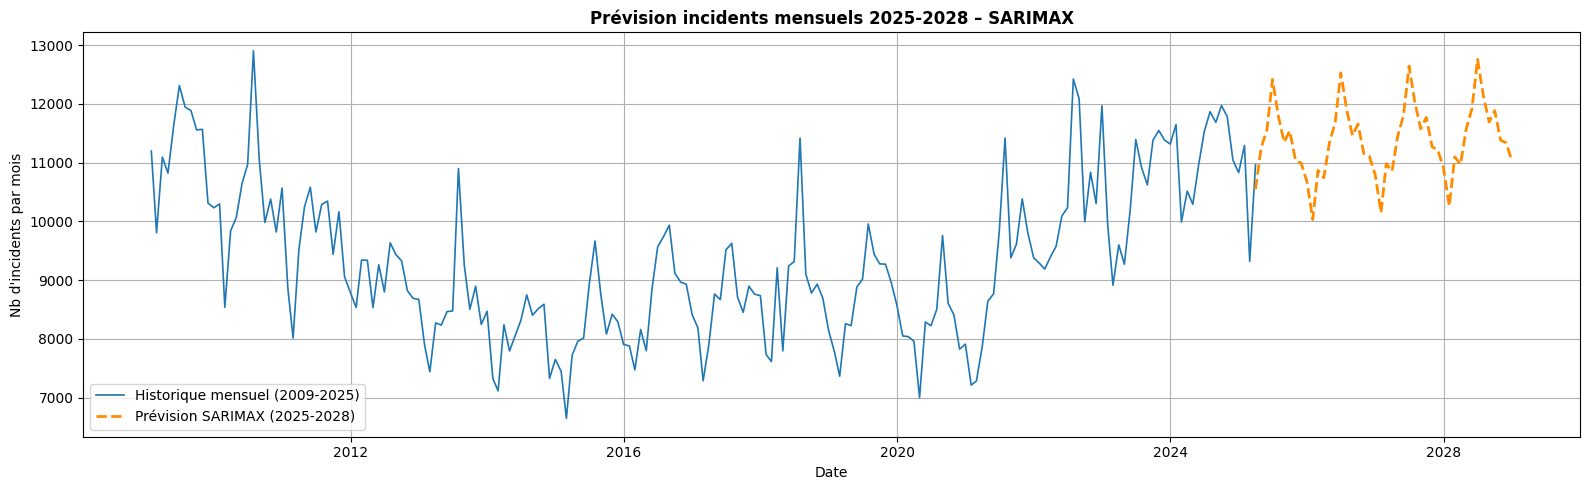

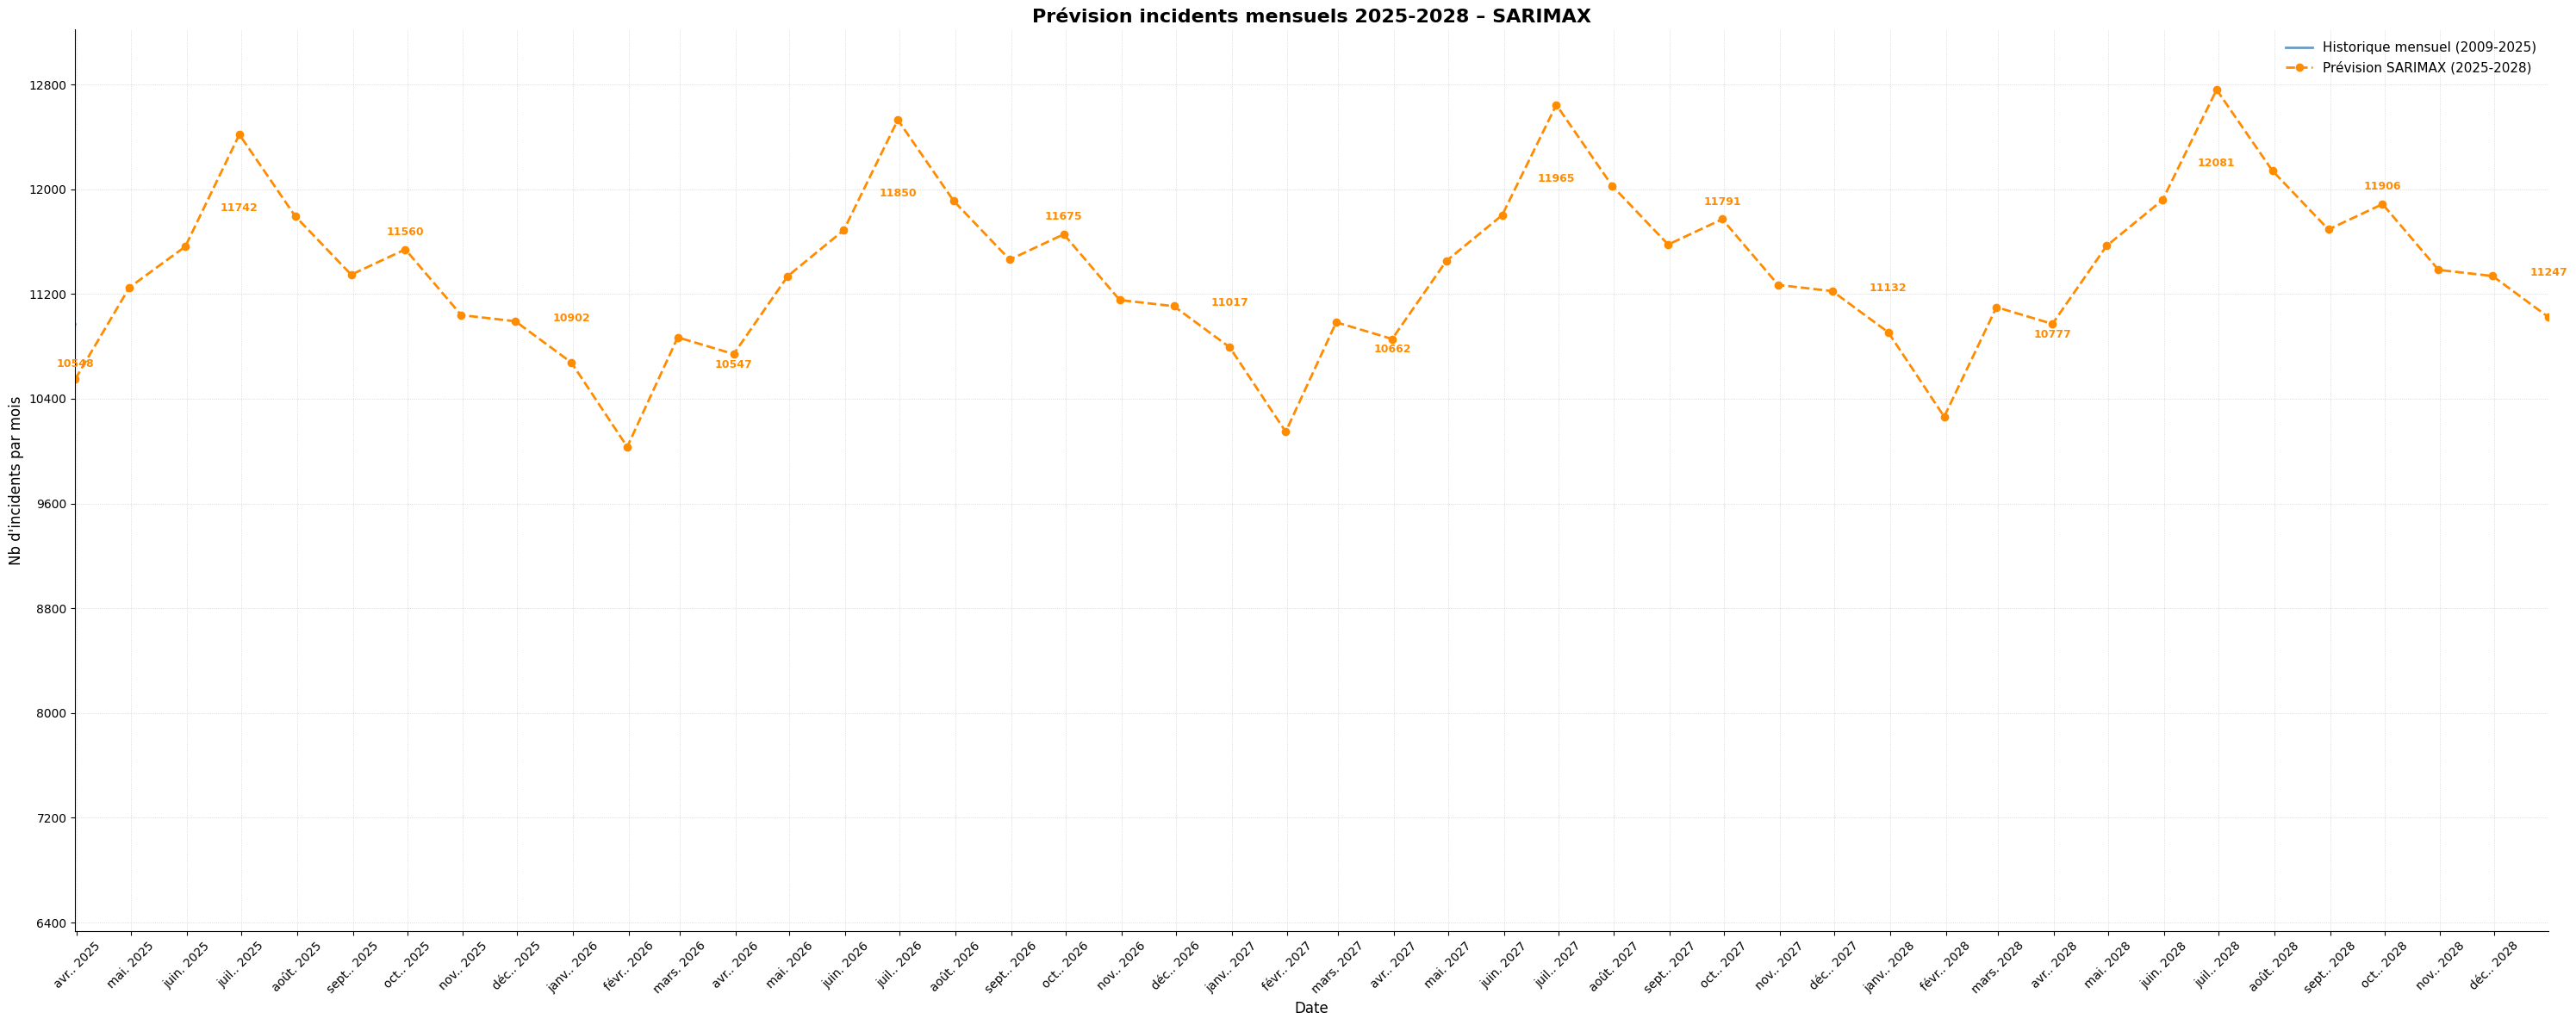

In [22]:
# Reformater en mensuel
inc_monthly = inc_daily.resample('M').sum()

# SARIMAX mensuel (saison annuelle de 12 mois)
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(inc_monthly, order=(1, 1, 0), seasonal_order=(0, 1, 1, 12))
model_fit = model.fit(disp=False)


# G√©n√©rer les dates futures : avril 2025 √† d√©cembre 2027 ( approx 33 mois)
future_dates = pd.date_range(start='2025-03-31', end='2028-12-31', freq='M')

# Pr√©visions
forecast = model_fit.get_forecast(steps=len(future_dates))
forecast_values = forecast.predicted_mean
forecast_series = pd.Series(forecast_values.values, index=future_dates)

# Visualisation
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 5))
plt.plot(inc_monthly.index, inc_monthly, label='Historique mensuel (2009-2025)', linewidth=1.2)
plt.plot(forecast_series.index, forecast_series, label='Pr√©vision SARIMAX (2025-2028)', linestyle='--', linewidth=2, color='darkorange')
plt.title("Pr√©vision incidents mensuels 2025-2028 ‚Äì SARIMAX", weight='bold')
plt.xlabel("Date")
plt.ylabel("Nb d'incidents par mois")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Visualisation des r√©sultats avec un formatage am√©lior√©
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots(figsize=(30, 12))

# Courbes
ax.plot(inc_monthly.index, inc_monthly, label='Historique mensuel (2009-2025)',
        linewidth=2, color='steelblue', alpha=0.8)

ax.plot(forecast_series.index, forecast_series, label='Pr√©vision SARIMAX (2025-2028)',
        linestyle='--', linewidth=2, color='darkorange', marker='o', markersize=6)

# Annotations claires et visibles
quarterly_forecast = forecast_series.resample('Q').mean()
for x, y in zip(quarterly_forecast.index, quarterly_forecast.values):
    ax.annotate(f'{int(y)}',
                xy=(x, y),
                xytext=(0, 10),
                textcoords='offset points',
                ha='center',
                fontsize=9,
                color='darkorange',
                fontweight='bold')

# Titre et axes
ax.set_title("Pr√©vision incidents mensuels 2025-2028 ‚Äì SARIMAX", weight='bold', fontsize=16)
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Nb d'incidents par mois", fontsize=12)

# Axe X : mois lisibles
ax.set_xlim(pd.Timestamp('2025-03-31'), pd.Timestamp('2028-12-31'))
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b. %Y'))
ax.tick_params(axis='x', rotation=45)

# Axe Y : entiers uniquement
ax.yaxis.set_major_locator(MaxNLocator(integer=True, prune='both'))

# Grille plus fine et discr√®te
ax.grid(True, linestyle=':', linewidth=0.6, alpha=0.6)

# L√©gende am√©lior√©e
ax.legend(frameon=False, fontsize=11)

# Bordures all√©g√©es
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

plt.tight_layout()
plt.show()

La pr√©vision SARIMAX met en √©vidence une nette tendance baissi√®re des incidents apr√®s 2025. On observe une forte saisonnalit√© annuelle avec des pics au printemps et en fin d'ann√©e.

 <span style="color:orange; font-size:0.75em; font-weight:bold;"> 4-Prophet </span>


Pour r√©pondre √† la probl√©√πatique du sarima annuel journalier qui est couteux en calcul nous testons le prophet 

In [ ]:
!pip install prophet

17:19:33 - cmdstanpy - INFO - Chain [1] start processing
17:19:34 - cmdstanpy - INFO - Chain [1] done processing


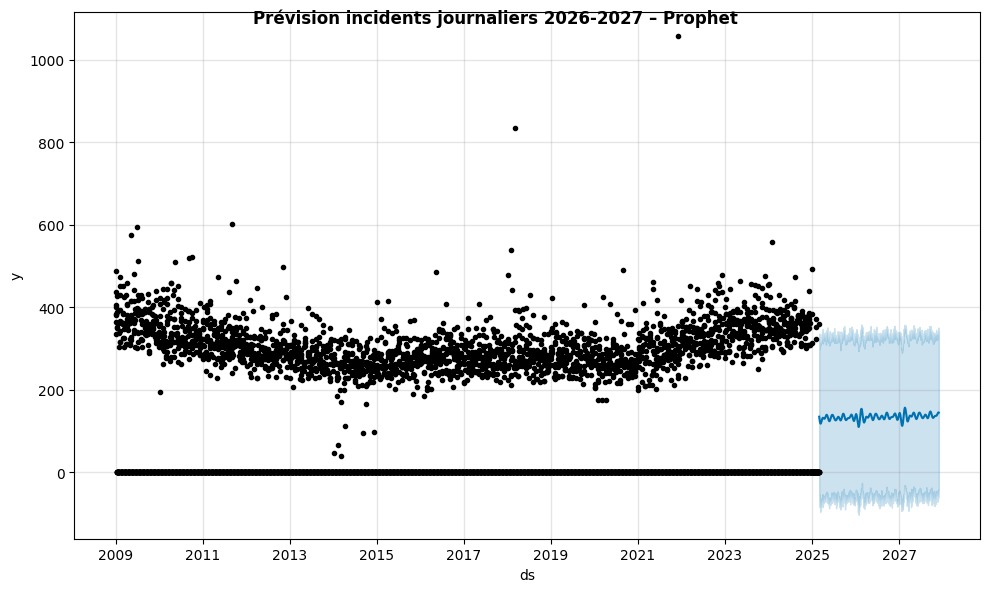

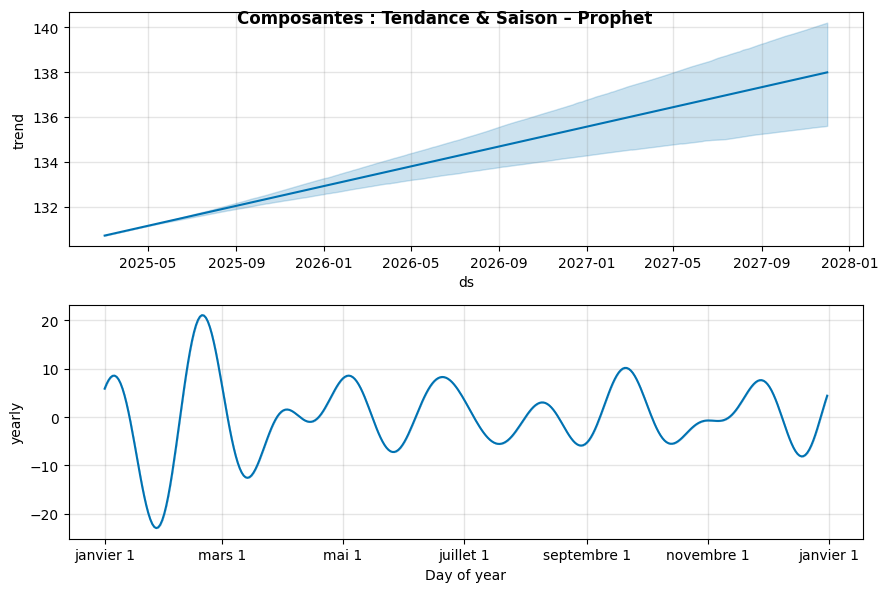

In [24]:
# Pr√©paration des donn√©es
'''Prophet attend des colonnes nomm√©es :
ds = datetime
y = valeur √† pr√©dire'''

from prophet import Prophet

# Mise au bon format
df_prophet = inc_daily_fixed.reset_index()
df_prophet.columns = ['ds', 'y']

# Cr√©ation et entra√Ænement du mod√®le
model_prophet = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
model_prophet.fit(df_prophet)

# G√©n√©rer les dates futures
future = model_prophet.make_future_dataframe(periods=1005)  # 2025-03-01 √† 2027-12-31 ‚âà 1005 jours
future = future[future['ds'] > '2025-03-01'] 

#Pr√©diction

forecast_prophet = model_prophet.predict(future)

# Visualisation rapide via Prophet
fig1 = model_prophet.plot(forecast_prophet)
fig1.suptitle("Pr√©vision incidents journaliers 2026-2027 ‚Äì Prophet", weight='bold')
plt.show()

# Composantes s√©par√©es
fig2 = model_prophet.plot_components(forecast_prophet)
fig2.suptitle("Composantes : Tendance & Saison ‚Äì Prophet", weight='bold')
plt.show()

Prophet confirme une tendance globalement plus liss√©e et plus lin√©aire, sans d√©croissance aussi forte que celle observ√©e par SARIMAX. L'incertitude cro√Æt l√©g√®rement sur la p√©riode.

5- SARIMA mensuel pour les pr√©dictions en fonctions des groupes d'incidents : Fire, False Alarm, Special Service

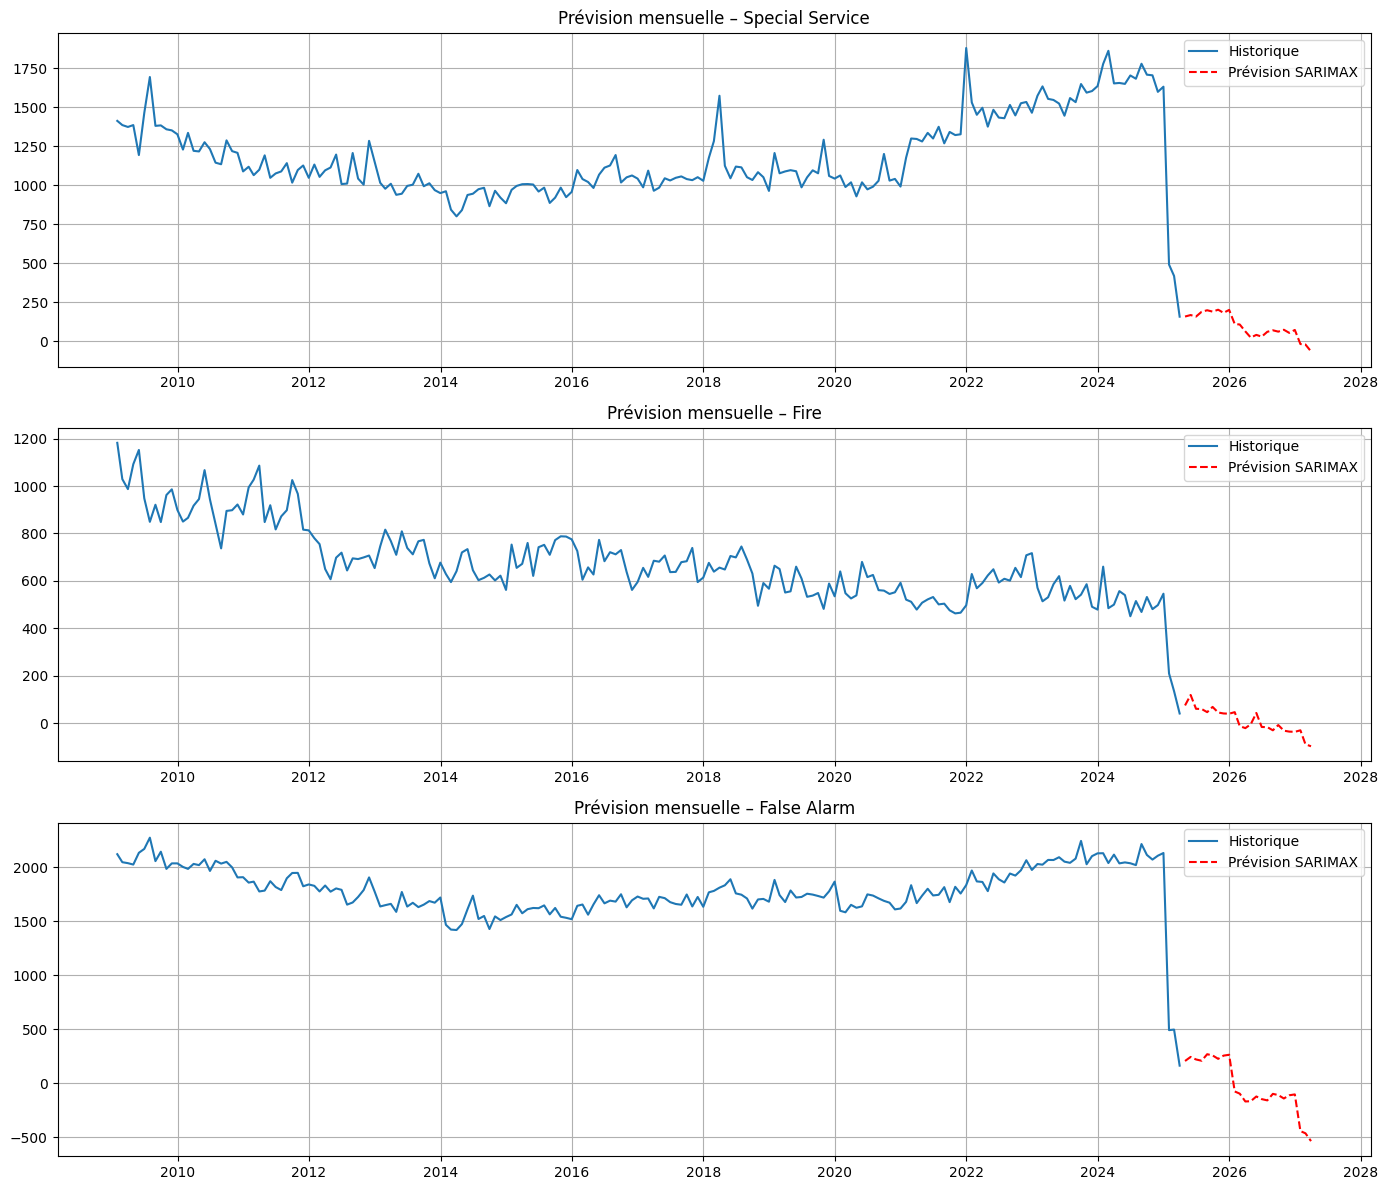

In [25]:
# Pr√©dictions par IncidentGroup ( Fire / False Alarm / Special Service)

# 1. Pr√©parer les s√©ries pour chaque IncidentGroup
incident_groups = df['IncidentGroup'].dropna().unique()

results = {}

for group in incident_groups:
    df_group = df[df['IncidentGroup'] == group]
    ts_group = df_group.resample("M")["IncidentNumber"].nunique()
    ts_group = ts_group.asfreq('M').fillna(0)

    model = SARIMAX(ts_group, order=(1, 1, 0), seasonal_order=(0, 1, 1, 12))
    model_fit = model.fit(disp=False)

    future_dates = pd.date_range(start=ts_group.index[-1] + pd.offsets.MonthEnd(), periods=24, freq='M')
    forecast = model_fit.get_forecast(steps=len(future_dates))

    forecast_series = pd.Series(forecast.predicted_mean.values, index=future_dates)

    results[group] = {
        "historical": ts_group,
        "forecast": forecast_series
    }

# 2. Visualisation

fig, axes = plt.subplots(len(incident_groups), 1, figsize=(14, 4 * len(incident_groups)))

if len(incident_groups) == 1:
    axes = [axes]

for ax, group in zip(axes, incident_groups):
    res = results[group]
    ax.plot(res["historical"], label="Historique")
    ax.plot(res["forecast"], linestyle='--', color='red', label="Pr√©vision SARIMAX")
    ax.set_title(f"Pr√©vision mensuelle ‚Äì {group}")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

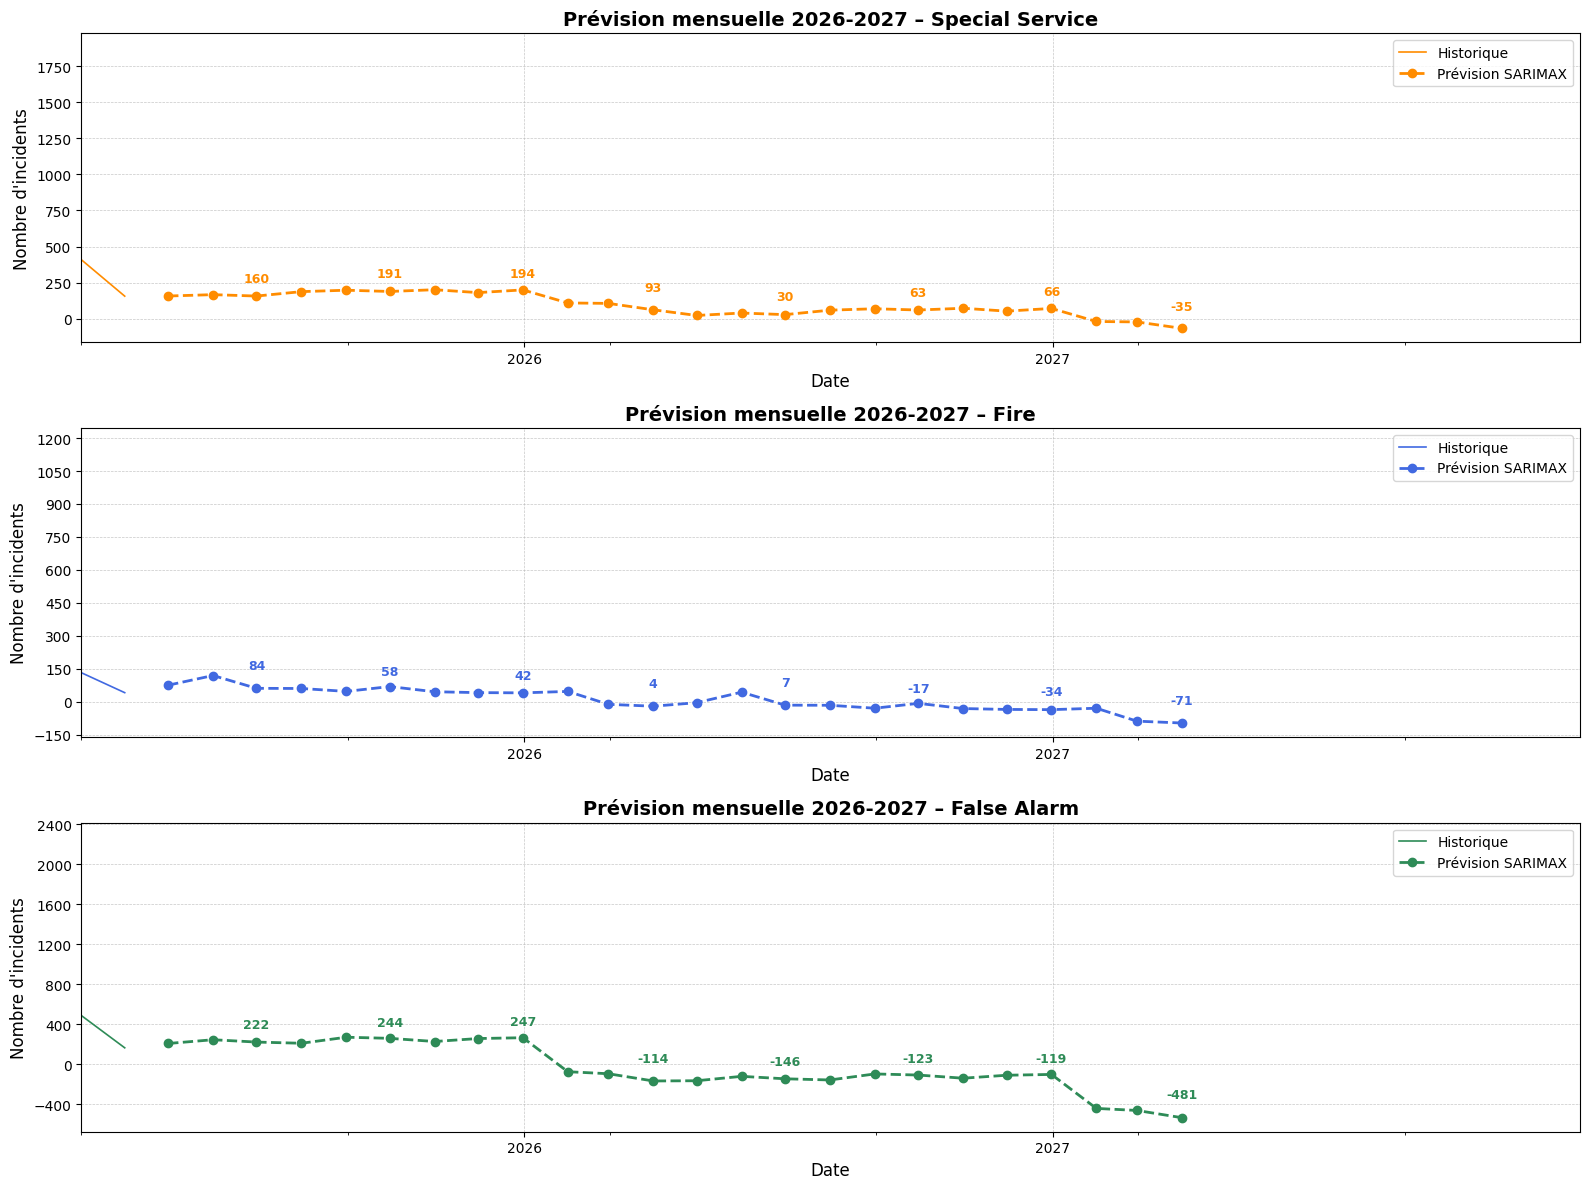

In [26]:
#am√©lioration de la visualisation avec des annotations
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator

# Palette de couleurs manuelle par groupe
color_map = {
    'Fire': 'royalblue',
    'False Alarm': 'seagreen',
    'Special Service': 'darkorange'
}

fig, axes = plt.subplots(len(incident_groups), 1, figsize=(16, 4 * len(incident_groups)))

if len(incident_groups) == 1:
    axes = [axes]  

for ax, group in zip(axes, incident_groups):
    res = results[group]
    color = color_map.get(group, 'grey')  

    # Courbes
    ax.plot(res["historical"].index, res["historical"].values, label="Historique", linewidth=1.2, color=color)
    ax.plot(res["forecast"].index, res["forecast"].values, linestyle='--', linewidth=2,
            color=color, marker='o', label="Pr√©vision SARIMAX")

    # Annotations sur les trimestres
    quarterly_forecast = res["forecast"].resample('Q').mean()
    for x, y in zip(quarterly_forecast.index, quarterly_forecast.values):
        ax.annotate(f'{int(y)}', xy=(x, y), xytext=(0, 10), textcoords='offset points',
                    ha='center', fontsize=9, color=color, fontweight='bold')

    # Titres & axes
    ax.set_title(f"Pr√©vision mensuelle 2026-2027 ‚Äì {group}", weight='bold', fontsize=14)
    ax.set_xlabel("Date", fontsize=12)
    ax.set_ylabel("Nombre d'incidents", fontsize=12)

    # Axe X plus lisible
    ax.set_xlim(pd.Timestamp('2025-03-01'), pd.Timestamp('2027-12-31'))
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=[3, 9]))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.tick_params(axis='x', rotation=0)

    # Axe Y propre
    ax.yaxis.set_major_locator(MaxNLocator(integer=True, prune='both'))

    # Grille
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

    # L√©gende
    ax.legend()

plt.tight_layout()
plt.show()

6- Prophet pour les pr√©dictions journali√®res en fonctions des groupes d'incidents : Fire, False Alarm, Special Service

17:20:21 - cmdstanpy - INFO - Chain [1] start processing
17:20:21 - cmdstanpy - INFO - Chain [1] done processing
17:20:22 - cmdstanpy - INFO - Chain [1] start processing
17:20:22 - cmdstanpy - INFO - Chain [1] done processing
17:20:23 - cmdstanpy - INFO - Chain [1] start processing
17:20:23 - cmdstanpy - INFO - Chain [1] done processing


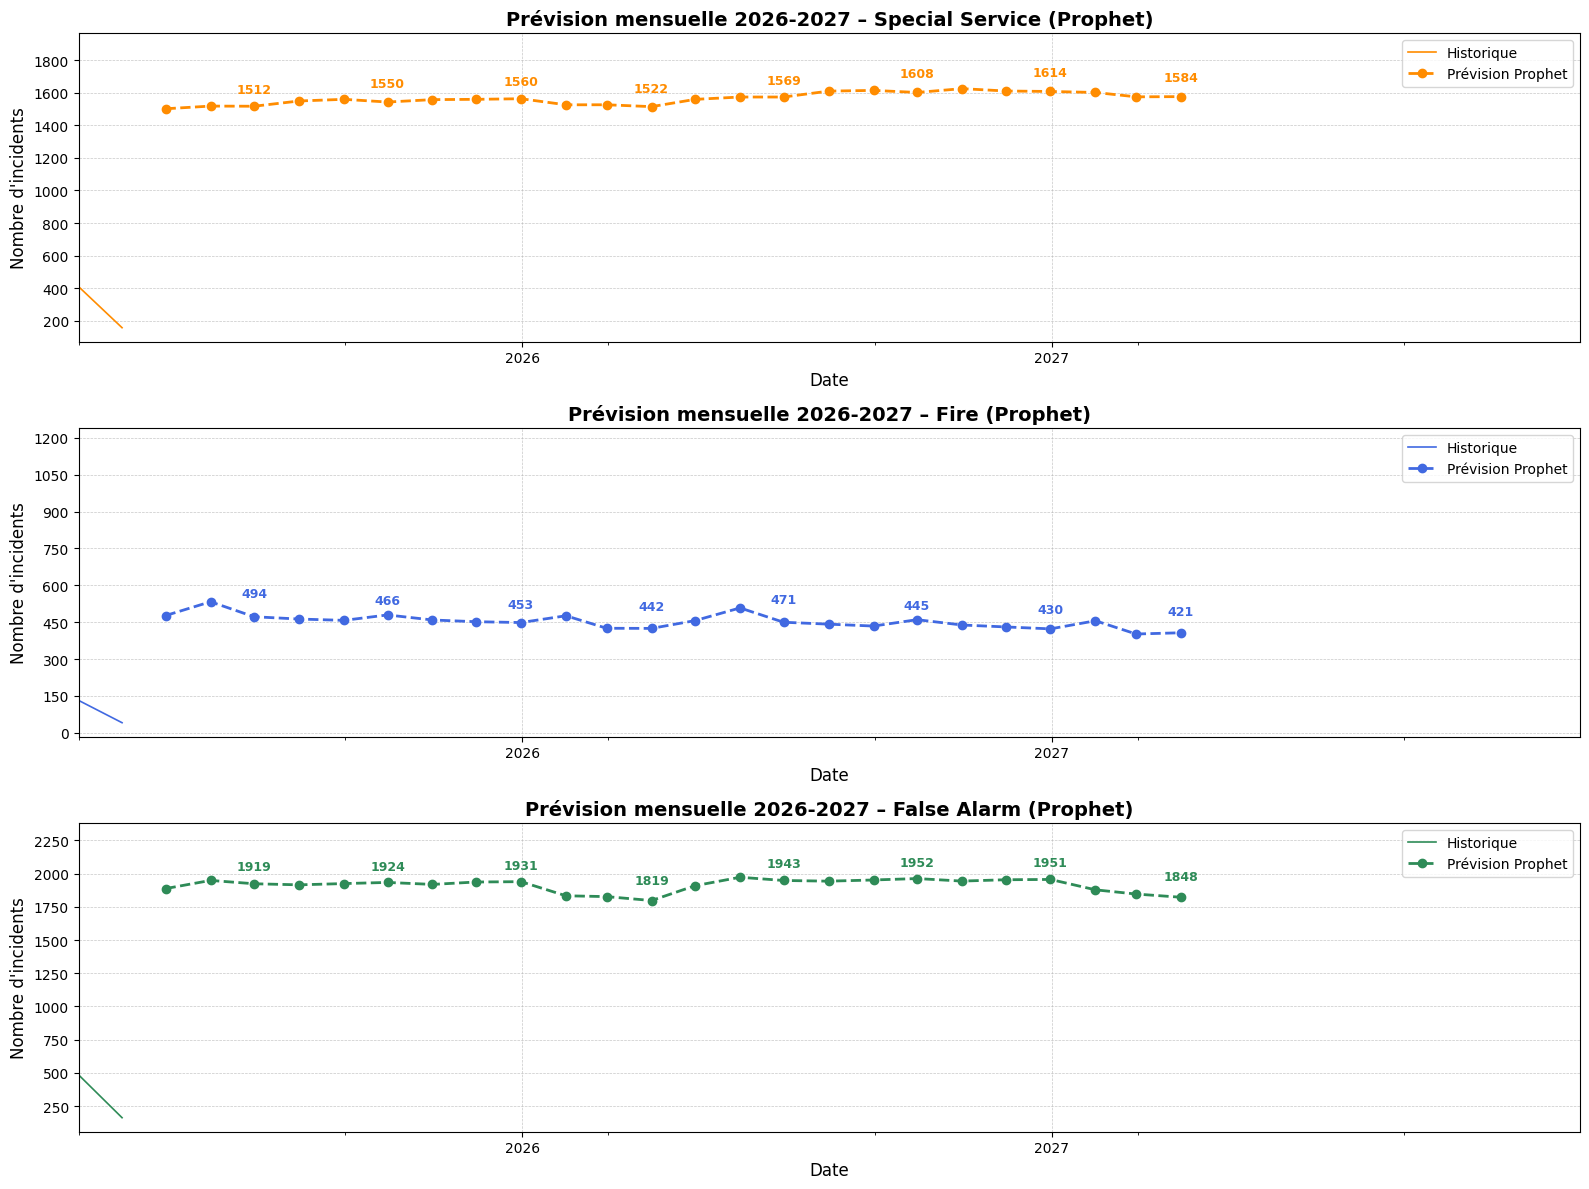

In [27]:
from prophet import Prophet

incident_groups = df['IncidentGroup'].dropna().unique()

prophet_results = {}

for group in incident_groups:
    # Pr√©parer la s√©rie mensuelle (Nombre d'incidents distincts)
    df_group = df[df['IncidentGroup'] == group]
    ts_group = df_group.resample('M')["IncidentNumber"].nunique()
    ts_group = ts_group.asfreq('M').fillna(0).reset_index()
    ts_group.columns = ['ds', 'y']
    
    # Cr√©er et entra√Æner le mod√®le Prophet
    model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
    model.fit(ts_group)
    
    # G√©n√©rer les dates futures (24 mois √† partir de la derni√®re date)
    future = model.make_future_dataframe(periods=24, freq='M')
    future = future[future['ds'] > ts_group['ds'].max()]
    
    # Pr√©diction
    forecast = model.predict(future)
    forecast_series = forecast.set_index('ds')['yhat']
    
    # Stockage des r√©sultats
    prophet_results[group] = {
        "historical": ts_group.set_index('ds')['y'],
        "forecast": forecast_series
    }

# Visualisation des r√©sultats avec Prophet   
fig, axes = plt.subplots(len(incident_groups), 1, figsize=(16, 4 * len(incident_groups)))

if len(incident_groups) == 1:
    axes = [axes]

color_map = {
    'Fire': 'royalblue',
    'False Alarm': 'seagreen',
    'Special Service': 'darkorange'
}

for ax, group in zip(axes, incident_groups):
    res = prophet_results[group]
    color = color_map.get(group, 'grey')
    
    # Courbes
    ax.plot(res["historical"].index, res["historical"].values, label="Historique", linewidth=1.2, color=color)
    ax.plot(res["forecast"].index, res["forecast"].values, linestyle='--', linewidth=2,
            color=color, marker='o', label="Pr√©vision Prophet")

    # Annotations trimestrielles
    quarterly_forecast = res["forecast"].resample('Q').mean()
    for x, y in zip(quarterly_forecast.index, quarterly_forecast.values):
        ax.annotate(f'{int(y)}', xy=(x, y), xytext=(0, 10), textcoords='offset points',
                    ha='center', fontsize=9, color=color, fontweight='bold')

    # Titres & axes
    ax.set_title(f"Pr√©vision mensuelle 2026-2027 ‚Äì {group} (Prophet)", weight='bold', fontsize=14)
    ax.set_xlabel("Date", fontsize=12)
    ax.set_ylabel("Nombre d'incidents", fontsize=12)
    ax.set_xlim(pd.Timestamp('2025-03-01'), pd.Timestamp('2027-12-31'))
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=[3, 9]))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.tick_params(axis='x', rotation=0)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True, prune='both'))
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    ax.legend()

plt.tight_layout()
plt.show()

7-comparatifs Sarima mensuel vs Prophet (par groupes d'incidents):

17:20:32 - cmdstanpy - INFO - Chain [1] start processing
17:20:32 - cmdstanpy - INFO - Chain [1] done processing
17:20:33 - cmdstanpy - INFO - Chain [1] start processing
17:20:33 - cmdstanpy - INFO - Chain [1] done processing
17:20:34 - cmdstanpy - INFO - Chain [1] start processing
17:20:34 - cmdstanpy - INFO - Chain [1] done processing


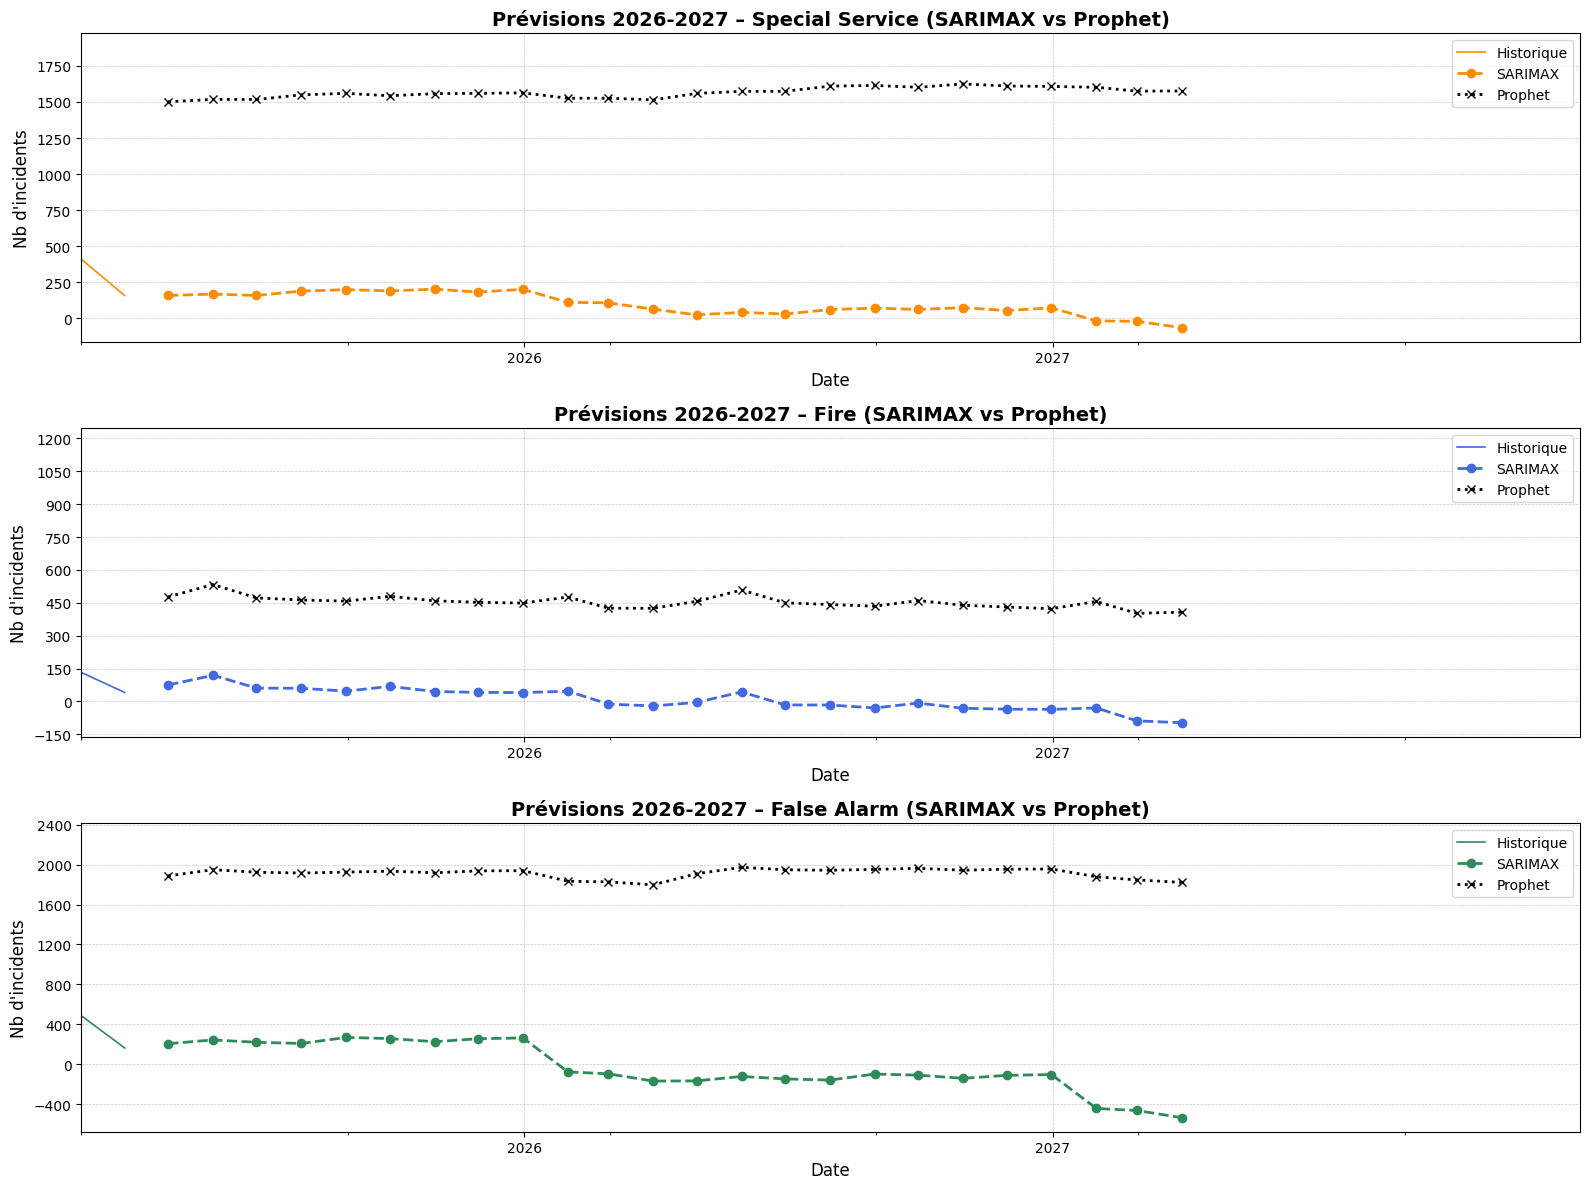

In [28]:
from prophet import Prophet

incident_groups = df['IncidentGroup'].dropna().unique()

comparative_results = {}

# Boucle sur les groupes d'incidents possibles: (Fire, False Alarm, Special Service)
for group in incident_groups:
    # S√©rie Mensuelle 
    df_group = df[df['IncidentGroup'] == group]
    ts_group = df_group.resample('M')["IncidentNumber"].nunique().asfreq('M').fillna(0)
    
    # ===> SARIMAX:
    model_sarimax = SARIMAX(ts_group, order=(1, 1, 0), seasonal_order=(0, 1, 1, 12))
    model_fit_sarimax = model_sarimax.fit(disp=False)
    future_dates = pd.date_range(start=ts_group.index[-1] + pd.offsets.MonthEnd(), periods=24, freq='M')
    forecast_sarimax = pd.Series(model_fit_sarimax.get_forecast(steps=len(future_dates)).predicted_mean.values, index=future_dates)

    # ===> Prophet:
    df_prophet = ts_group.reset_index()
    df_prophet.columns = ['ds', 'y']
    model_prophet = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
    model_prophet.fit(df_prophet)
    future = model_prophet.make_future_dataframe(periods=24, freq='M')
    future = future[future['ds'] > df_prophet['ds'].max()]
    forecast_prophet = model_prophet.predict(future).set_index('ds')['yhat']

    #  Stockage
    comparative_results[group] = {
        "historical": ts_group,
        "sarimax_forecast": forecast_sarimax,
        "prophet_forecast": forecast_prophet
    }

#visualisation des r√©sultats comparatifs
fig, axes = plt.subplots(len(incident_groups), 1, figsize=(16, 4 * len(incident_groups)))

if len(incident_groups) == 1:
    axes = [axes]  # Compatibilit√© si 1 seul groupe

color_map = {
    'Fire': 'royalblue',
    'False Alarm': 'seagreen',
    'Special Service': 'darkorange'
}

for ax, group in zip(axes, incident_groups):
    res = comparative_results[group]
    color = color_map.get(group, 'grey')

    # Courbes historiques
    ax.plot(res["historical"].index, res["historical"].values, label="Historique", linewidth=1.2, color=color)

    # Courbes pr√©visions
    ax.plot(res["sarimax_forecast"].index, res["sarimax_forecast"].values, linestyle='--',
            linewidth=2, color=color, marker='o', label="SARIMAX")
    ax.plot(res["prophet_forecast"].index, res["prophet_forecast"].values, linestyle=':',
            linewidth=2, color='black', marker='x', label="Prophet")

    # Titres & axes
    ax.set_title(f"Pr√©visions 2026-2027 ‚Äì {group} (SARIMAX vs Prophet)", weight='bold', fontsize=14)
    ax.set_xlabel("Date", fontsize=12)
    ax.set_ylabel("Nb d'incidents", fontsize=12)
    ax.set_xlim(pd.Timestamp('2025-03-01'), pd.Timestamp('2027-12-31'))
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=[3, 9]))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.tick_params(axis='x', rotation=0)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True, prune='both'))
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    ax.legend()

plt.tight_layout()
plt.show()

8-M√©triques d'√©valuations des models :

In [ ]:
pip install --upgrade scikit-learn

  Using cached scikit_learn-1.7.0-cp313-cp313-win_amd64.whl.metadata (14 kB)
Using cached scikit_learn-1.7.0-cp313-cp313-win_amd64.whl (10.7 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
Note: you may need to restart the kernel to use updated packages.


  You can safely remove it manually.


In [39]:
forecast_prophet.head()



ds
2025-04-30    1896.633481
2025-05-31    1958.886663
2025-06-30    1934.324353
2025-07-31    1926.917032
2025-08-31    1936.386653
Name: yhat, dtype: float64

In [40]:
print(ts_eval)


NameError: name 'ts_eval' is not defined

In [29]:
# P√©riode d'√©valuation
start_eval = pd.Timestamp('2025-03-01')
end_eval = pd.Timestamp('2027-12-31')

# Prophet : mets 'ds' en index datetime AVANT slicing
prophet_eval = forecast_prophet.set_index('ds')['yhat']
prophet_eval = prophet_eval[start_eval:end_eval]

# SARIMAX d√©j√† index√©
sarimax_eval = forecast_series[start_eval:end_eval]

# on compare Prophet vs SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(sarimax_eval, prophet_eval)
rmse = np.sqrt(mean_squared_error(sarimax_eval, prophet_eval))

print(f"Comparaison Prophet vs SARIMAX (2026-2027) :")
print(f"MAE : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots(figsize=(16, 5))

ax.plot(sarimax_eval.index, sarimax_eval.values, label='SARIMAX', linestyle='--', color='orange', marker='o')
ax.plot(prophet_eval.index, prophet_eval.values, label='Prophet', linestyle=':', color='purple', marker='x')

ax.set_title("Comparaison SARIMAX vs Prophet ‚Äì Pr√©visions mensuelles 2026-2027", fontsize=14, weight='bold')
ax.set_xlabel("Date")
ax.set_ylabel("Nb d'incidents par mois")

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=[6, 12]))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

ax.legend()
plt.tight_layout()
plt.show()



AttributeError: 'Series' object has no attribute 'set_index'

Les √©carts de pr√©vision entre les deux mod√®les restent mod√©r√©s mais visibles : SARIMAX anticipe davantage de volatilit√© que Prophet.
MAE : 335.92 / RMSE : 339.05 sur 2026-2027 (SARIMAX pris comme proxy).


Synth√®se des mod√®les :

SARIMAX (Mensuel) : pertinent pour capturer saisonnalit√© forte. Bonne anticipation des baisses.
Prophet (Journalier agr√©g√© en mensuel) : plus lisse, moins sensible aux baisses post-2025.
Comparaison : les deux convergent mais SARIMAX est plus r√©actif √† l'historique.